# `XGBoost` ML training for Cosmic Ray Veto optimisation

## Objective
Optimize the veto condition to maximize cosmic ray purity while minimizing pileup contamination.

**Run tag:** `e`

- Apply full selection cuts 
- Here we use the "best" CRV coincidence per event via central deltaT index
- We do this so that we can produce efficiency and deadtime metrics which are understandable by the CRV group
- Optimise for veto efficiency of >=99.9%
- Employ more inclusive CRV-focused feature set: ['dT', 'crv_z', 'crv_y', 'crv_x', 'angle', 'nLayers', 'PEs', 'nHits']
- Including NaN values: these will reduce efficiency and deadtime, since they contribute to the denominator in both cases

## Preprocessing
- Execution: `run/run_ml_prep.py`
- Core logic: `src/core/ml_process.py`

## Training datasets

### Mixed CE (background - label 0)
- `nts.mu2e.CeEndpointMix2BBTriggered.MDC2020aw_best_v1_3_v06_06_00.root`

### Pure CRY (signal - label 1)
- `nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020aw_perfect_v1_3_v06_06_00.root`

## Training strategy

Discriminate between:
1. Coincidences from **mixed CE**
2. Coincidences from **pure CRY**

## Future implementation 
Discriminate between:
1. Coincidences from **mixed CE**
2. Coincidences from **mixed CRY** (cosmic-produced only, identified via MC truth)

In [1]:
# System tools  
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore") # suppress warnings

# Python stack 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# ML tools
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# Internal modules 
sys.path.extend(["../../../src/core", "../../../src/utils"])
from draw import Draw
from io_manager import Load

# pyutils 
from pyutils.pyplot import Plot
plotter = Plot() # just use this for styles

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## Load data

In [2]:
!ls -ltrh ../../../output/ml/veto/e/data

total 0
drwxr-sr-x. 2 sgrant 65534 4 Nov 20 21:23 CE_mix_onspill-LH_aw
drwxr-sr-x. 2 sgrant 65534 4 Nov 20 21:26 CRY_onspill-LH_aw


In [3]:
run = "e"
base_in_path = Path(f"../../../output/ml/veto/{run}/data/")
cry_in_path = base_in_path / "CRY_onspill-LH_aw"
ce_mix_in_path = base_in_path/ "CE_mix_onspill-LH_aw"

cry_data = Load(in_path=cry_in_path).load_pkl()
ce_mix_data = Load(in_path=ce_mix_in_path).load_pkl()

[Load] ✅ Initialised with out_path=../../../output/ml/veto/e/data/CRY_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../../output/ml/veto/e/data/CRY_onspill-LH_aw/results.pkl
[Load] ✅ Initialised with out_path=../../../output/ml/veto/e/data/CE_mix_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../../output/ml/veto/e/data/CE_mix_onspill-LH_aw/results.pkl


## Verify data

In [4]:
display(cry_data["cut_flow"])
display(ce_mix_data["cut_flow"])

,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,2610933,100.000,100.000,No selection applied
1,has_trk_front,Preselect,2558235,97.982,97.982,Tracks intersect tracker entrance
2,has_trk_mid,Preselect,2558229,97.981,100.000,Tracks intersect tracker middle
3,is_reco_electron,Preselect,2478081,94.912,96.867,Electron track fits
4,one_reco_electron,Preselect,2050975,78.553,82.765,One reco electron / event
5,is_downstream,Preselect,1127230,43.173,54.961,Has downstream track (p_z > 0 in tracker)
6,is_truth_electron,Preselect,320790,12.286,28.458,Track parents are electrons (truth PID)
7,good_trkqual,Tracker,253943,9.726,79.162,Track fit quality > 0.2
8,within_t0,Tracker,203324,7.787,80.067,t0 at tracker mid (640 < t_0 < 1650 ns)
9,within_t0err,Tracker,188703,7.227,92.809,Track fit t0 uncertainty (t0err < 0.9 ns)


,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,1339362,100.000,100.000,No selection applied
1,has_trk_front,Preselect,1336979,99.822,99.822,Tracks intersect tracker entrance
2,has_trk_mid,Preselect,1336978,99.822,100.000,Tracks intersect tracker middle
3,is_reco_electron,Preselect,1327517,99.116,99.292,Electron track fits
4,one_reco_electron,Preselect,1097128,81.914,82.645,One reco electron / event
5,is_downstream,Preselect,1096128,81.840,99.909,Has downstream track (p_z > 0 in tracker)
6,is_truth_electron,Preselect,1096059,81.834,99.994,Track parents are electrons (truth PID)
7,good_trkqual,Tracker,883133,65.937,80.573,Track fit quality > 0.2
8,within_t0,Tracker,655446,48.937,74.218,t0 at tracker mid (640 < t_0 < 1650 ns)
9,within_t0err,Tracker,636329,47.510,97.083,Track fit t0 uncertainty (t0err < 0.9 ns)


[Load] ✅ Initialised with out_path=test_out
[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[Plot] ⭐️ Initialised
CRY
[Plot] ✅ 	Wrote ../../../output/images/ml/veto/e/xgboost/preparation/h1o_3x3_cuts_CRY.png


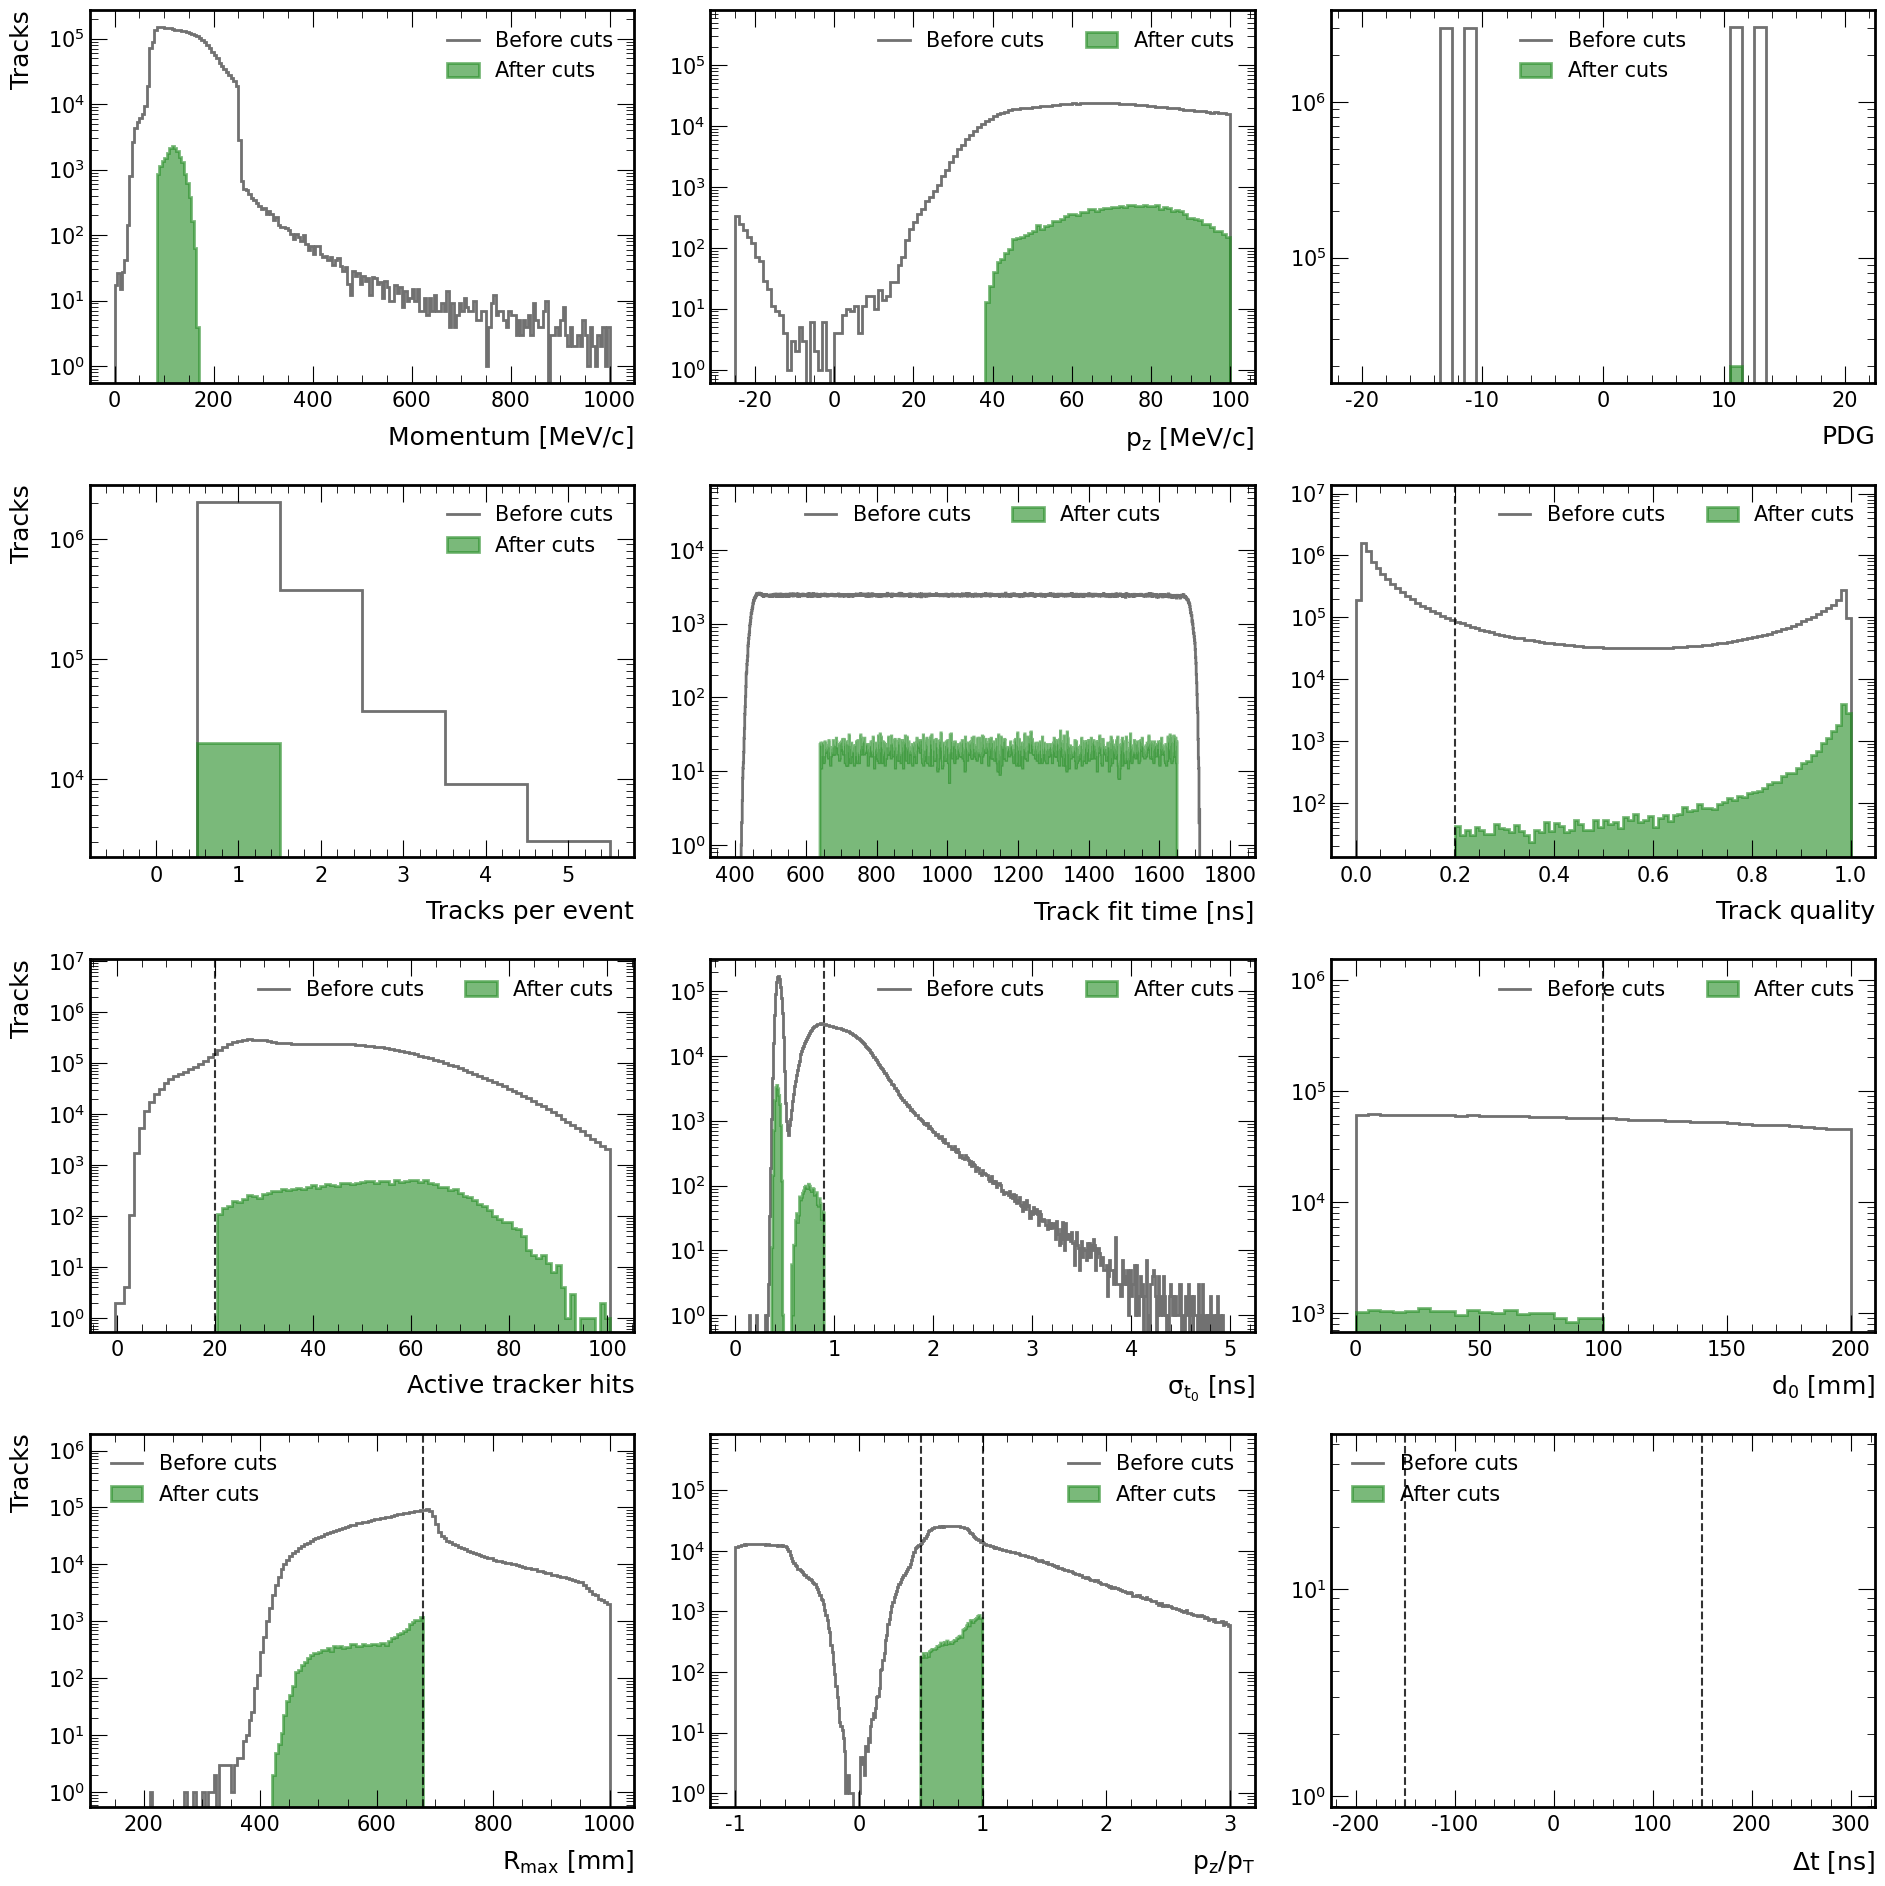

SIGNAL + PILEUP
[Plot] ✅ 	Wrote ../../../output/images/ml/veto/e/xgboost/preparation/h1o_3x3_cuts_CE_mix.png


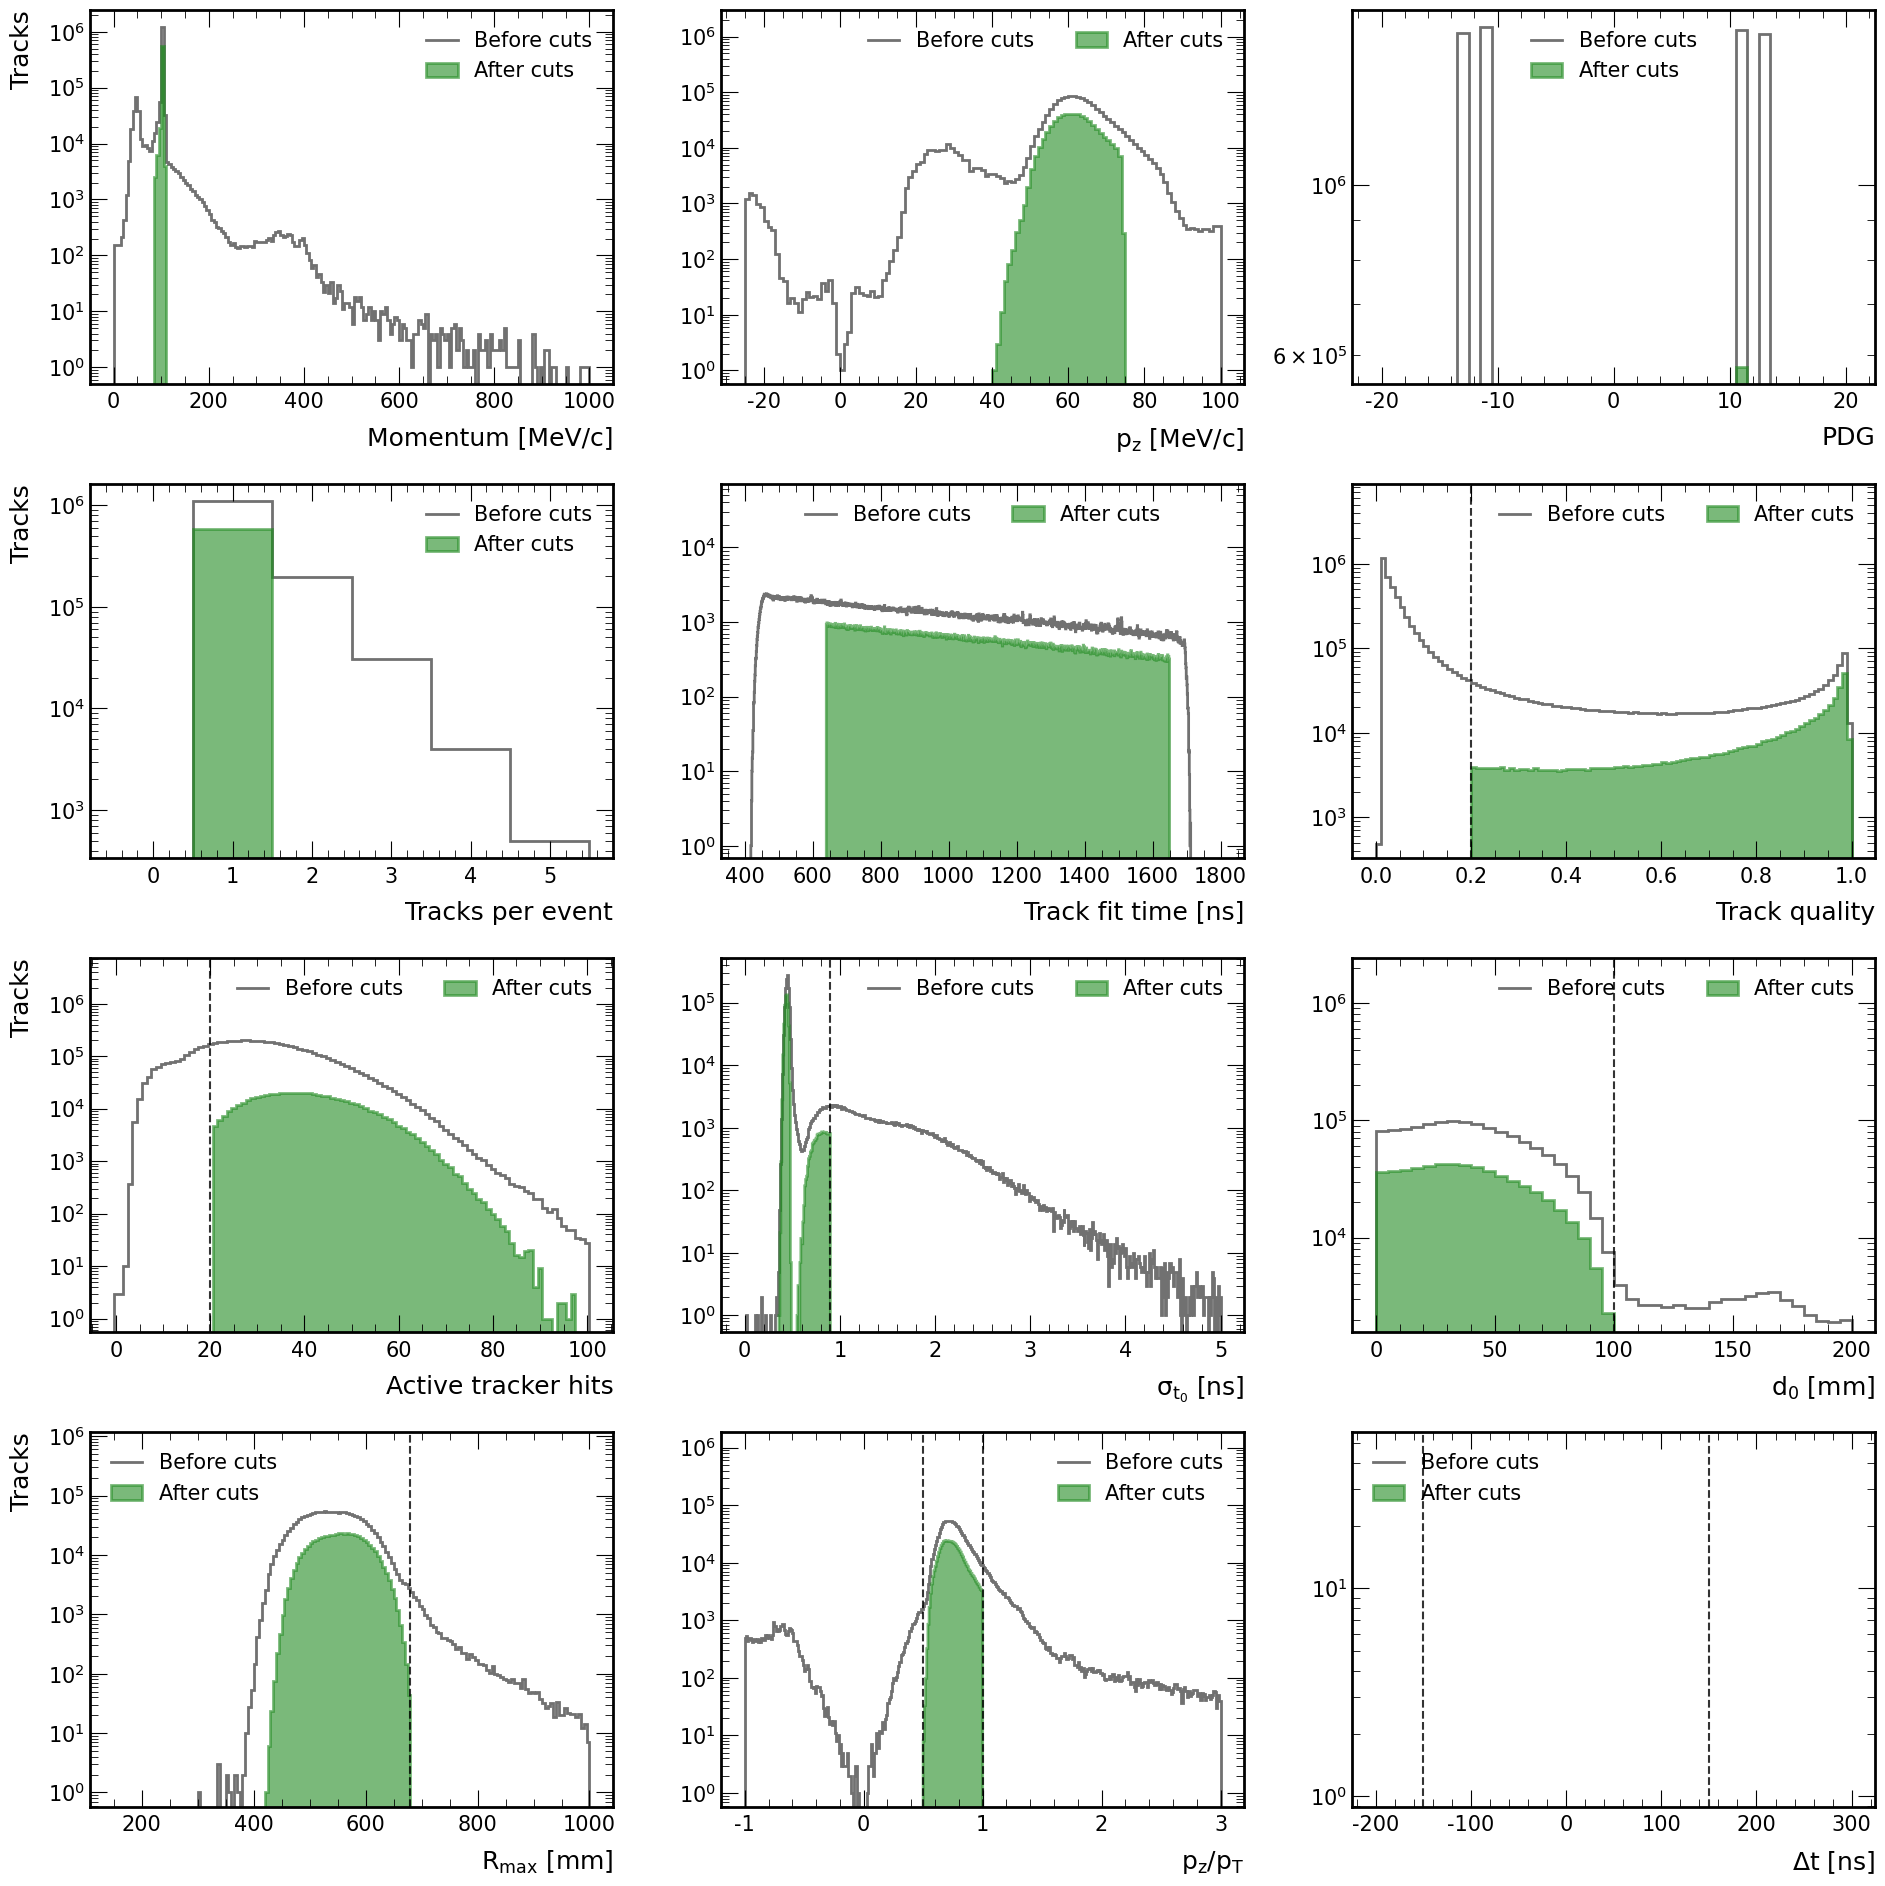

In [5]:
draw = Draw()

img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
img_feature_out_path = img_base_path / "preparation"
img_feature_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_feature_out_path / "h1o_2x2_features.png"

print("CRY")
draw.plot_ml_summary(cry_data["hists"], out_path = img_feature_out_path / "h1o_3x3_cuts_CRY.png")

print("SIGNAL + PILEUP")
draw.plot_ml_summary(ce_mix_data["hists"], out_path = img_feature_out_path / "h1o_3x3_cuts_CE_mix.png")

In [6]:
print(cry_data["events"].type)
print(ce_mix_data["events"].type)

20087 * {event: float64, subrun: float64, crv_x: float64, crv_y: float64, crv_z: float64, PEs: float64, dT: float64, nHits: float64, nLayers: float64, angle: float64, PEs_per_hit: float64, t0: float64, d0: float64, tanDip: float64, maxr: float64, mom_mag: float64}
578372 * {event: float64, subrun: float64, crv_x: float64, crv_y: float64, crv_z: float64, PEs: float64, dT: float64, nHits: float64, nLayers: float64, angle: float64, PEs_per_hit: float64, t0: float64, d0: float64, tanDip: float64, maxr: float64, mom_mag: float64}


In [7]:
from pyutils.pyprint import Print
Print().print_n_events(ce_mix_data["events"], 2)

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyprint] ⭐️ Printing 2 event(s)...

-------------------------------------------------------------------------------------
event: 2.0
subrun: 6.0
crv_x: 4390.083984375
crv_y: 2869.350830078125
crv_z: -9957.7998046875
PEs: 1148.18798828125
dT: 238.35714821382112
nHits: 50.0
nLayers: 4.0
angle: 0.37940457463264465
PEs_per_hit: 22.963759765625
t0: 749.9485788778836
d0: 2.9947686195373535
tanDip: 0.7312529683113098
maxr: 537.523193359375
mom_mag: 103.11563110351562
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
event: 6.0
subrun: 6.0
crv_x: 3879.52783203125
crv_y: 2875.791748046875
crv_z: -9957.7998046875
PEs: 22692.7578125
dT: 26.38739573202804
nHits: 1048.0
nLayers: 4.0
angle: -0.9804540276527405
PEs_per_hit: 21.653394859255727
t0: 1023.040716044528
d0: 53.74258041381836
tanDip: 0.82459473609924

## Feature plots

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
	Wrote ../../../output/images/ml/veto/e/xgboost/features/h1o_2x4_crv_features.png


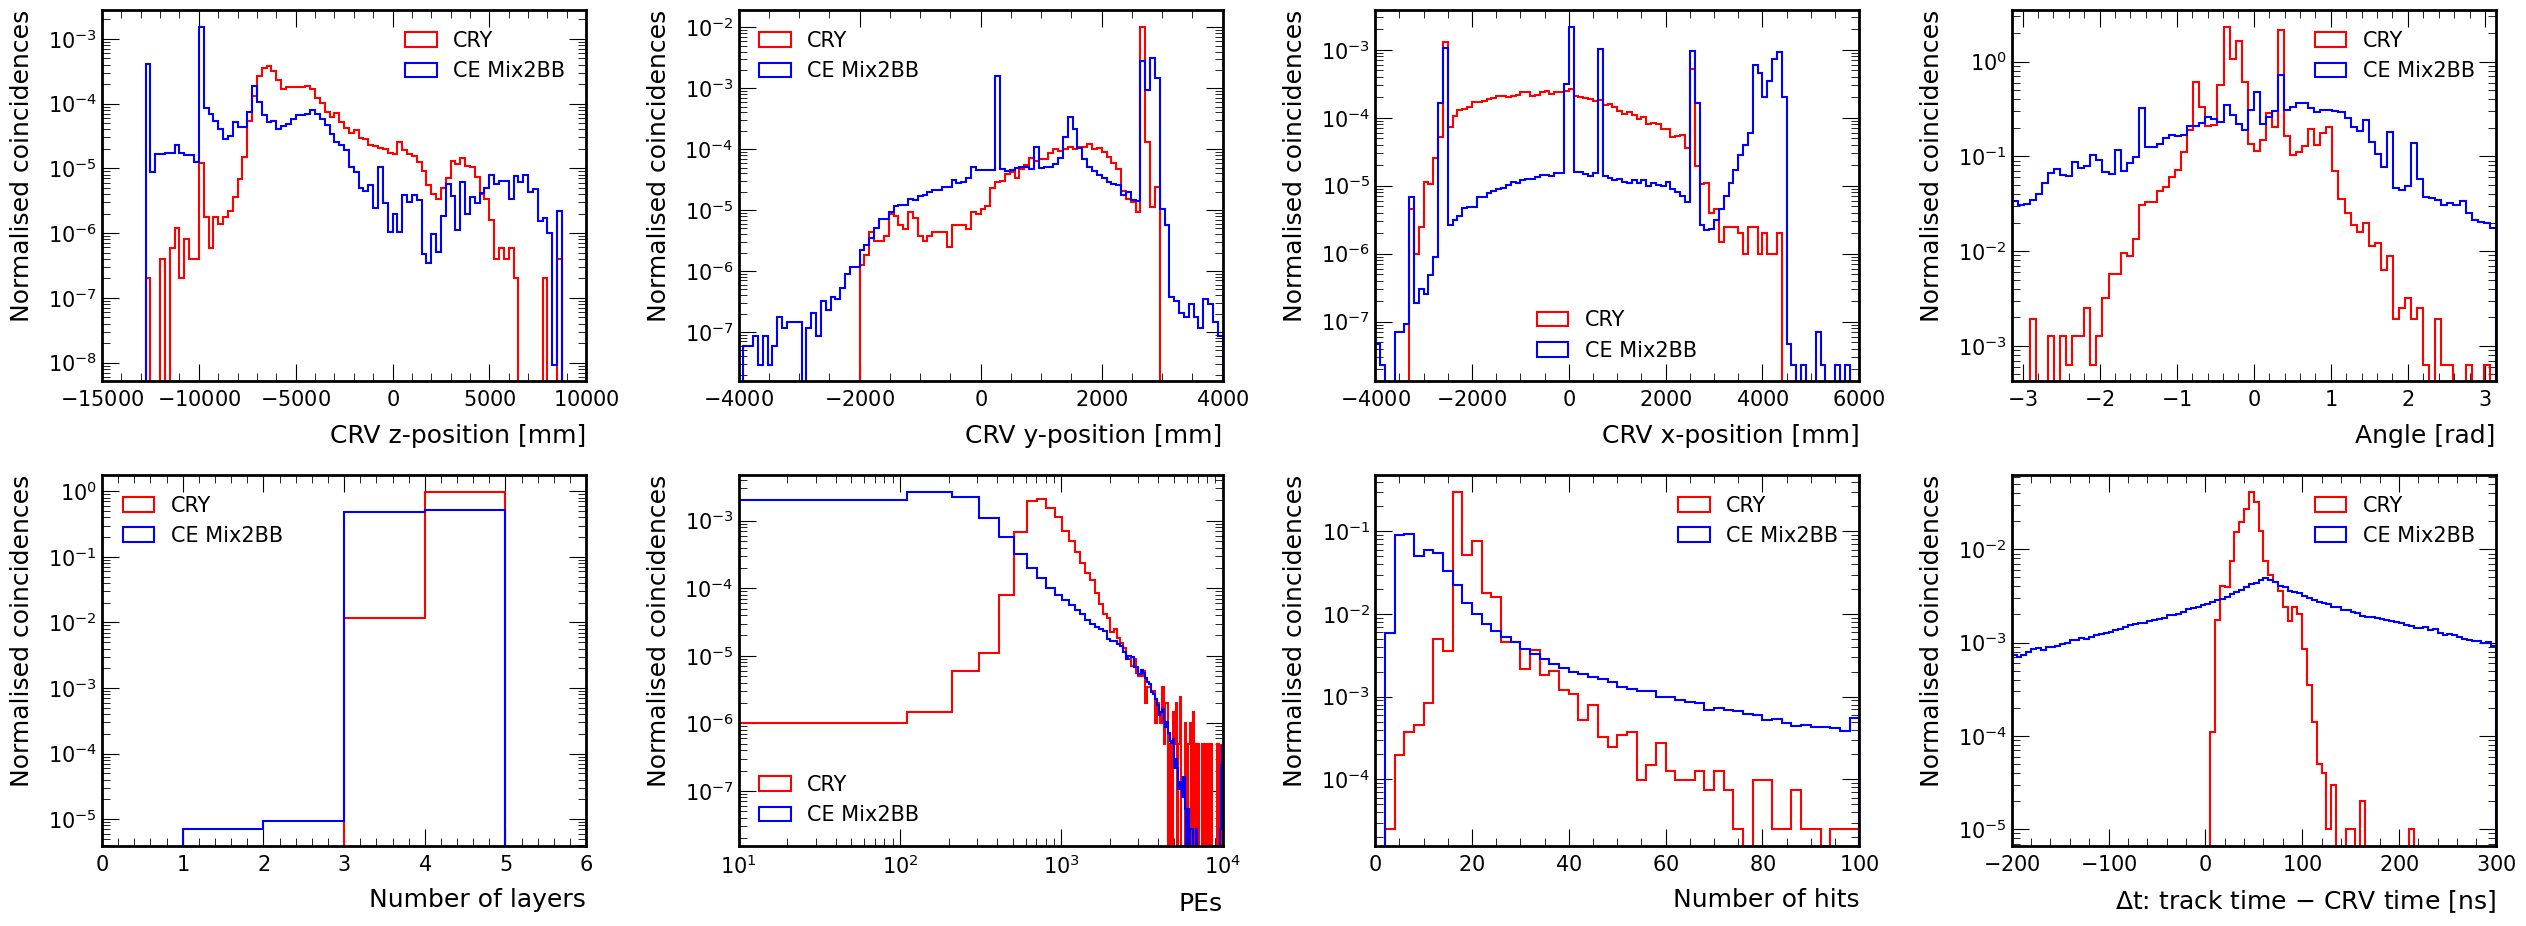

In [8]:
from pyutils.pyplot import Plot 
plotter = Plot()
fig, ax = plt.subplots(2, 4, figsize=(4*6.4, 2*4.8))
styles = {
    "CRY" : { 
        "color" : "red",
    },
    "CE Mix2BB" : {
        "color" : "blue",
    }
}

# Plot 1: CRV z-position - increase bins for smoother distribution
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["crv_z"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["crv_z"], axis=-1),
    },
    nbins=100,  # Reduced from 250 for cleaner look
    xmin=-15000,
    xmax=10000,
    show=False,
    ax=ax[0,0],
    log_y=True,
    xlabel="CRV z-position [mm]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 2: CRV y-position - focus on main peak region
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["crv_y"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["crv_y"], axis=-1),
    },
    nbins=100,  # Reduced from 200
    xmin=-4000,
    xmax=4000,
    show=False,
    ax=ax[0,1],
    log_y=True,
    xlabel="CRV y-position [mm]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 3: CRV x-position - focus on populated region
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["crv_x"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["crv_x"], axis=-1),
    },
    nbins=100,  # Reduced from 200
    xmin=-4000,
    xmax=6000,
    show=False,
    ax=ax[0,2],
    log_y=True,
    xlabel="CRV x-position [mm]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 4: Angle - smoother binning
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["angle"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["angle"], axis=-1),
    },
    nbins=80,  # Reduced from 200 for smoother curves
    xmin=-3.14159,
    xmax=3.14159,  
    show=False,
    ax=ax[0,3],
    log_y=True,
    xlabel="Angle [rad]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 5: Number of layers - discrete values
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["nLayers"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["nLayers"], axis=-1),
    },
    nbins=6,
    xmin=0,
    xmax=6,
    show=False,
    ax=ax[1,0],
    log_y=True,
    xlabel="Number of layers", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 6: CRV PEs - fewer bins for log scale
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["PEs"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["PEs"], axis=-1),
    },
    nbins=100,  # Much fewer bins for log scale
    xmin=10,  # Start at 10 to avoid log(0)
    xmax=1e4,
    show=False,
    ax=ax[1,1],
    log_y=True,
    log_x=True,
    xlabel="PEs", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 7: Number of hits - better resolution in main region
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["nHits"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["nHits"], axis=-1),
    },
    nbins=50,  # Reduced from 100
    xmin=0,
    xmax=100,
    show=False,
    ax=ax[1,2],
    log_y=True,
    log_x=False,
    xlabel=r"Number of hits", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 8: dT - focus on peak region
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["dT"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["dT"], axis=-1),
    },
    nbins=100,  # Reduced from 250 for cleaner look
    xmin=-200,
    xmax=300,
    show=False,
    ax=ax[1,3],
    log_y=True,
    log_x=False,
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

plt.tight_layout()
img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
img_feature_out_path = img_base_path / "features"
img_feature_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_feature_out_path / "h1o_2x4_crv_features.png"
plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()

	Wrote ../../../output/images/ml/veto/e/xgboost/features/h2o_dT_vs_z.png


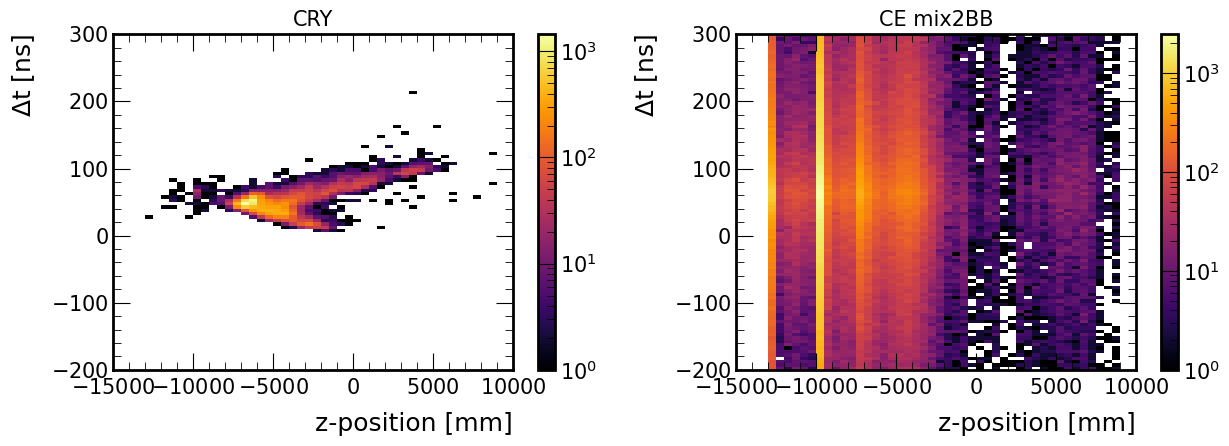

In [9]:
fig, ax = plt.subplots(1,2,figsize=(2*6.4, 4.8))
plotter.plot_2D(
    x = ak.flatten(cry_data["events"]["crv_z"], axis=-1),
    y = ak.flatten(cry_data["events"]["dT"], axis=-1),
    nbins_x=50,
    xmin=-15000,
    xmax=10000,
    nbins_y=100,
    ymin=-200,
    ymax=300,
    show=False,
    log_z=True,
    xlabel="z-position [mm]", 
    ylabel=r"$\Delta t$ [ns]", 
    title="CRY",
    ax=ax[0]
)
plotter.plot_2D(
    x = ak.flatten(ce_mix_data["events"]["crv_z"], axis=-1),
    y = ak.flatten(ce_mix_data["events"]["dT"], axis=-1),
    nbins_x=50,
    xmin=-15000,
    xmax=10000,
    nbins_y=100,
    ymin=-200,
    ymax=300,
    show=False,
    log_z=True,
    xlabel="z-position [mm]", 
    ylabel=r"$\Delta t$ [ns]", 
    title="CE mix2BB",
    ax=ax[1]
)

plt.tight_layout()
out_name = img_feature_out_path / "h2o_dT_vs_z.png"

plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()

## Training 

In [10]:
# Convert to DataFrame
df_CRY = ak.to_dataframe(cry_data["events"])
df_sig_mix = ak.to_dataframe(ce_mix_data["events"])

# Drop unused columns
col_to_drop = ["event", "subrun", "d0", "tanDip", "maxr", "mom_mag", "PEs_per_hit", "t0"] 

df_CRY.drop(columns=col_to_drop, axis=1, inplace=True)
df_sig_mix.drop(columns=col_to_drop, axis=1, inplace=True)

df_CRY["label"] = 1 # "signal"
df_sig_mix["label"] = 0 # "background"

In [11]:
print(ak.is_none(ce_mix_data["events"]["PEs"], axis=-1))
print(ak.any(ak.is_none(ce_mix_data["events"]["PEs"], axis=-1), axis=None))
print(ce_mix_data["events"]["PEs"])

[False, False, False, False, False, ..., False, False, False, False, False]
False
[1.15e+03, 2.27e+04, 145, 44.7, nan, 459, ..., 314, 205, 46.6, 204, 398]


In [12]:
# Combine and shuffle
df_train = pd.concat([df_CRY, df_sig_mix], ignore_index=True)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
display(df_train)

,crv_x,crv_y,crv_z,PEs,dT,nHits,nLayers,angle,label
0,6.362000e+02,392.602814,-12563.242188,145.083633,64.463831,11.0,4.0,-1.123515,0
1,-2.602413e+03,275.529999,-3046.652832,73.935631,271.628521,5.0,3.0,-0.111414,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.000000e+00,2687.724121,-5035.093262,46.534462,113.290321,3.0,3.0,0.365511,0
4,0.000000e+00,2690.055420,-7764.437500,90.661423,-6.660609,6.0,3.0,-1.892229,0
...,...,...,...,...,...,...,...,...,...
598454,4.547474e-13,2726.687012,-9743.940430,117.777496,195.624744,5.0,3.0,-1.717686,0
598455,4.232896e+03,2879.032959,-9957.799805,260.041809,-383.717315,16.0,4.0,1.215436,0
598456,6.362000e+02,1678.593872,-12568.070312,11484.034180,-1.233973,651.0,4.0,0.633537,0
598457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [13]:
X = df_train.drop("label", axis=1)
y = df_train["label"]

# Define feature names from actual columns
feature_names = list(X.columns)
print(f"Features: {feature_names}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining: {len(X_train)} events")
print(f"Test: {len(X_test)} events")

Features: ['crv_x', 'crv_y', 'crv_z', 'PEs', 'dT', 'nHits', 'nLayers', 'angle']

Training: 478767 events
Test: 119692 events


In [14]:
# Actually not really needed for BDTs

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")

✅ Features scaled


In [15]:
print("\n🚀 Training XGBoost model...")

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Assign feature names for plotting / saving
model.get_booster().feature_names = feature_names

print("✅ Training complete!")


🚀 Training XGBoost model...
✅ Training complete!


## Store model

In [16]:
model_out_path = Path(f"../../../output/ml/veto/{run}/models")
model_out_path.mkdir(parents=True, exist_ok=True)


# Full path to model file
model_file_path = model_out_path / "trained_xgboost.json"

# Save the model
model.save_model(str(model_file_path))  # XGBoost often needs string path
print(f"\n✅ Done! Model saved to {model_file_path}")


✅ Done! Model saved to ../../../output/ml/veto/e/models/trained_xgboost.json


## Analyse model 

In [17]:
feature_names = model.get_booster().feature_names
feature_names

['crv_x', 'crv_y', 'crv_z', 'PEs', 'dT', 'nHits', 'nLayers', 'angle']


⭐️ Feature importance:
  crv_x     : 0.0069
  crv_y     : 0.0098
  crv_z     : 0.3880
  PEs       : 0.2281
  dT        : 0.0246
  nHits     : 0.0105
  nLayers   : 0.3070
  angle     : 0.0252
	Wrote ../../../output/images/ml/veto/e/xgboost/validation/bar_feature_importance.png


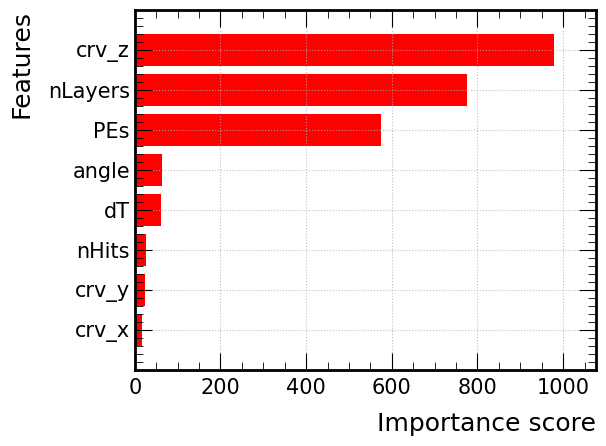

In [18]:
print("\n⭐️ Feature importance:") 
for feat, imp in zip(feature_names, model.feature_importances_):
    print(f"  {feat:10s}: {imp:.4f}") 

xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.8)
plt.title("")
plt.tight_layout()

# img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
img_validation_out_path = img_base_path / "validation"
img_validation_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_validation_out_path / "bar_feature_importance.png"
plt.savefig(out_name)

print(f"\tWrote {out_name}")
# out_name = img_out_path / "bar_feature_importance.png" 
# plt.savefig(out_name)
plt.show()

In [19]:
train_pred = model.predict_proba(X_train_scaled)[:, 1]
test_pred = model.predict_proba(X_test_scaled)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
test_auc = roc_auc_score(y_test, test_pred)

print(f"\nTraining AUC: {train_auc:.6f}")
print(f"Test AUC: {test_auc:.6f}")


Training AUC: 0.999886
Test AUC: 0.999948


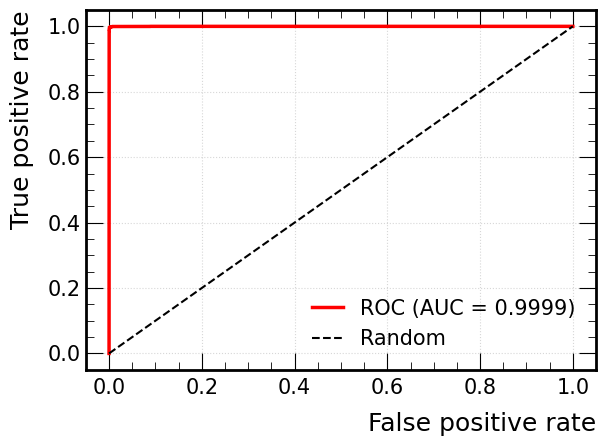


✅ Done! ROC curve saved to ../../../output/images/ml/veto/e/xgboost/validation/roc_curve.png


In [20]:
fpr, tpr, _ = roc_curve(y_test, test_pred)

plt.figure()
plt.plot(fpr, tpr, linewidth=2.5, label=f'ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.tight_layout()

out_name = img_validation_out_path /  "roc_curve.png"
plt.savefig(out_name)
plt.show()

print(f"\n✅ Done! ROC curve saved to {out_name}")

In [21]:
# Are there duplicate events?
print(f"Train events: {len(X_train)}")
print(f"Test events: {len(X_test)}")
print(f"Overlap: {len(set(X_train.index) & set(X_test.index))}")
print(feature_names)

Train events: 478767
Test events: 119692
Overlap: 0
['crv_x', 'crv_y', 'crv_z', 'PEs', 'dT', 'nHits', 'nLayers', 'angle']


In [22]:
print(img_validation_out_path)

../../../output/images/ml/veto/e/xgboost/validation


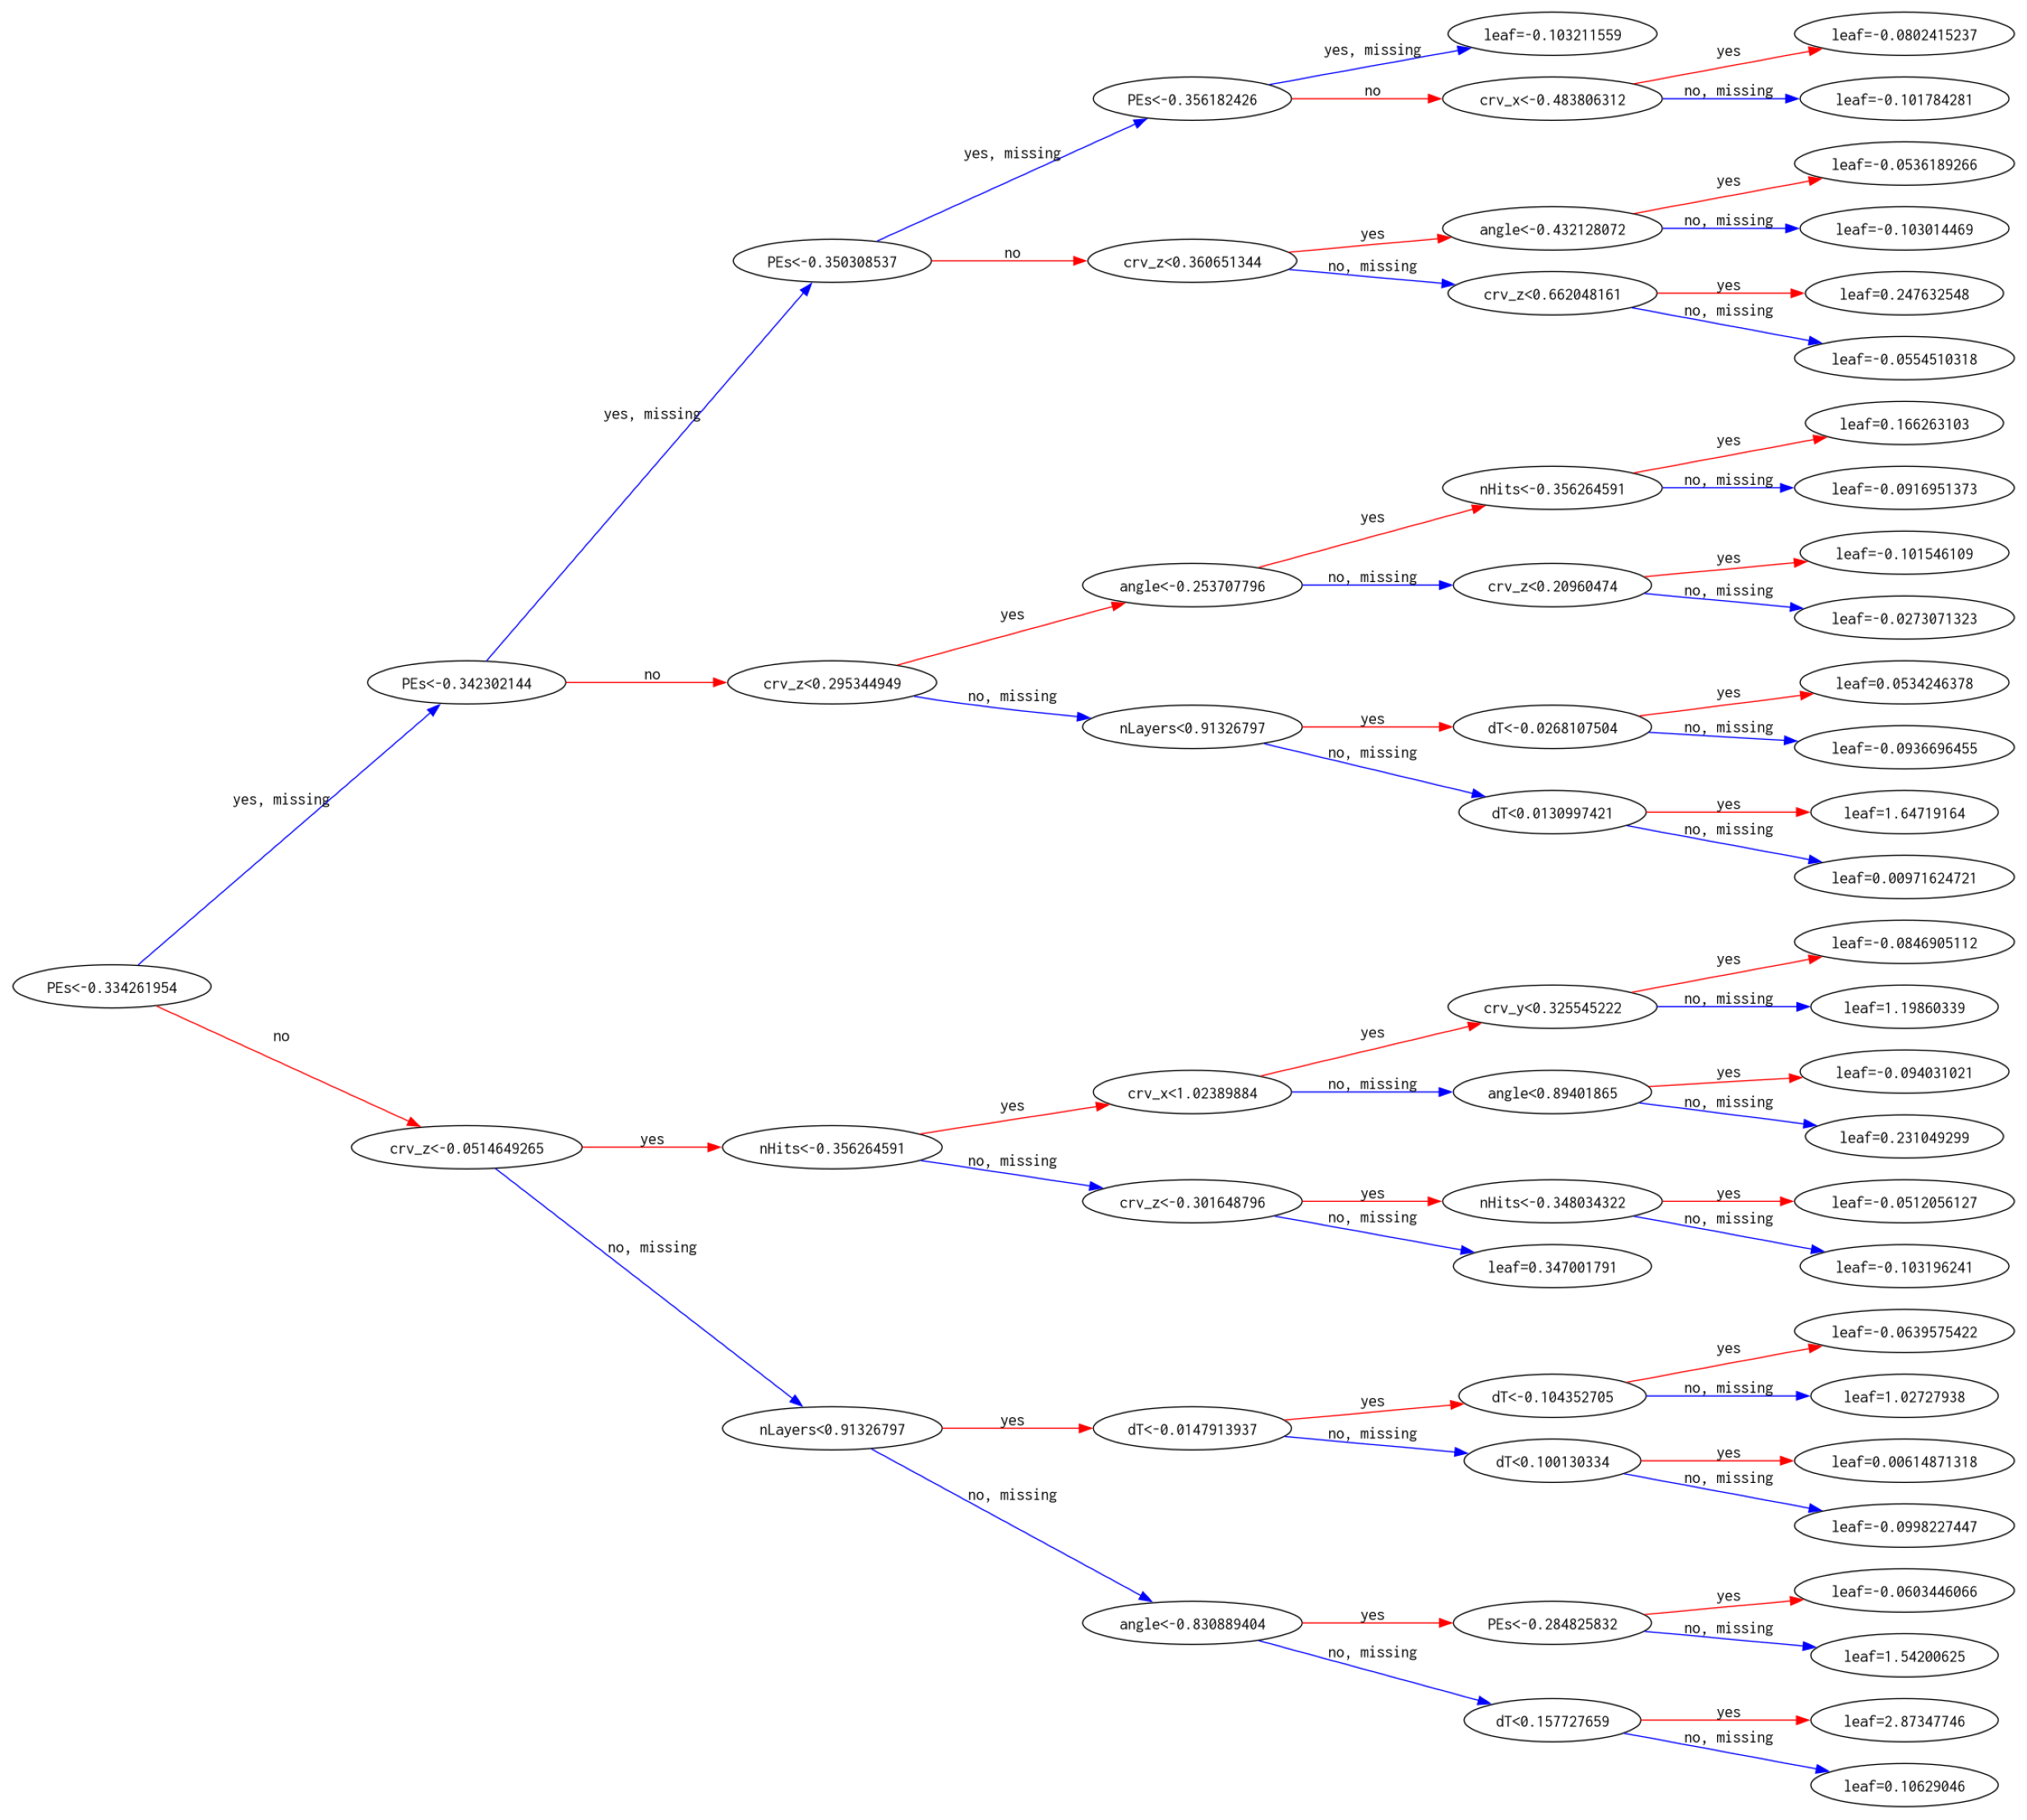


✅ Done! Tree saved to ../../../output/images/ml/veto/e/xgboost/validation/tree_mix.png


In [23]:
fig, ax = plt.subplots(figsize=(25, 25))
xgb.plot_tree(model, num_trees=0, rankdir="LR", ax=ax)
plt.tight_layout()

out_name = img_validation_out_path / "tree_mix.png"
plt.savefig(out_name)
plt.show()

print(f"\n✅ Done! Tree saved to {out_name}")

## Model output histogram 

	Wrote ../../../output/images/ml/veto/e/xgboost/validation/h1o_model_output.png


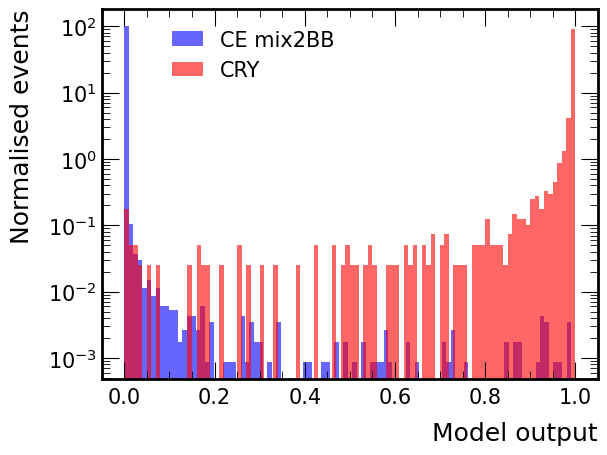

In [24]:
# Get test scores 
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # CRY
background_scores = test_scores[y_test == 0]  # CE + mix2BB

# Plot score distributions
plt.figure() 

plt.hist(background_scores, bins=100, alpha=0.6, label='CE mix2BB',
         density=True, color='blue')
plt.hist(signal_scores, bins=100, alpha=0.6, label='CRY',
         density=True, color='red')

plt.xlabel('Model output')
plt.ylabel('Normalised events')
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1))
plt.yscale('log')

out_name = img_validation_out_path / "h1o_model_output.png"
plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()




In [25]:
background_scores

array([4.9857085e-06, 3.3350992e-05, 5.1053736e-05, ..., 4.3813761e-06,
       5.1053736e-05, 1.5284699e-05], dtype=float32)

## Threshold optimisation 


Threshold optimisation results




,Strategy,Threshold,Veto efficiency,Deadtime,Figure of merit
0,Signal significance,0.584,99.03%,0.03%,0.9900
1,Efficiency >= 99.9%,0.003,99.90%,0.64%,0.9926
2,Balanced FOM,0.024,99.78%,0.20%,0.9957



✅ Threshold optimisation plot saved to ../../../output/images/ml/veto/e/xgboost/validation/threshold_optimisation.png


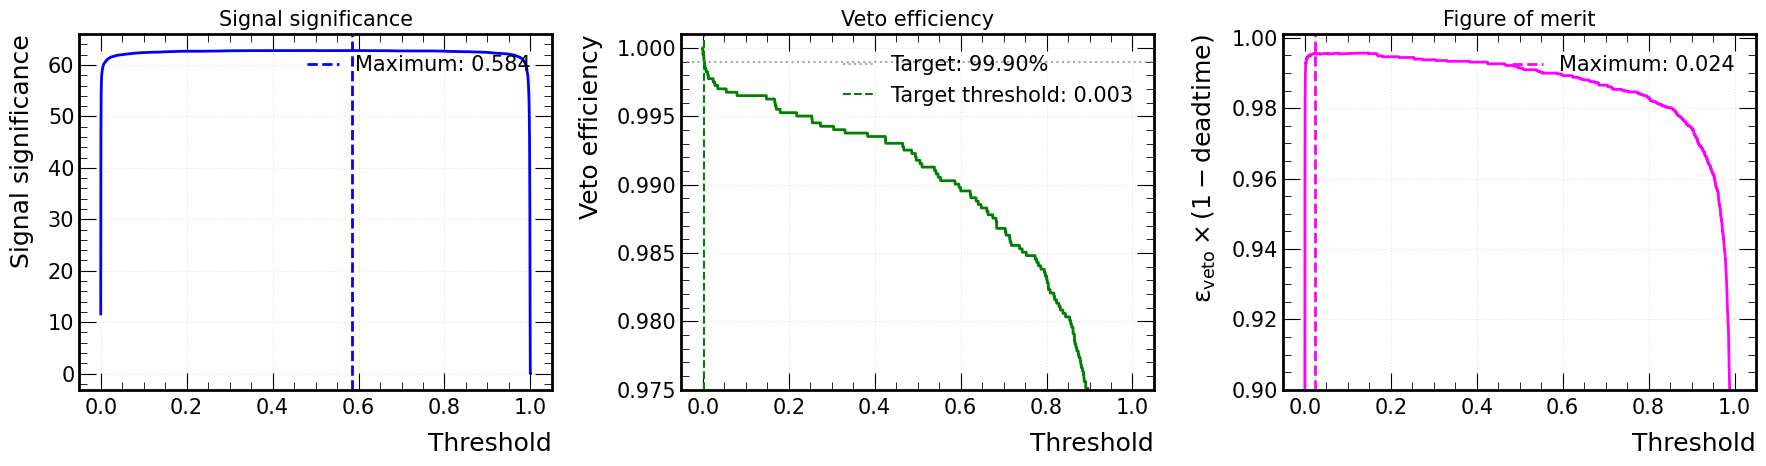

In [26]:
thresholds = np.linspace(0, 1, 10000)

# Calculate all metrics in a single loop
veto_efficiencies = []
deadtime_losses = []
significance_values = []

for thr in thresholds:
    y_pred_label = (test_pred > thr).astype(int)
    
    # Calculate confusion matrix elements
    tp = ((y_test == 1) & (y_pred_label == 1)).sum()
    fn = ((y_test == 1) & (y_pred_label == 0)).sum()
    fp = ((y_test == 0) & (y_pred_label == 1)).sum()
    tn = ((y_test == 0) & (y_pred_label == 0)).sum()
    
    # Veto efficiency and deadtime
    veto_eff = tp / (tp + fn) if (tp + fn) > 0 else 0
    deadtime = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    veto_efficiencies.append(veto_eff)
    deadtime_losses.append(deadtime)
    
    # Signal significance (S/root(S+B))
    significance = tp / np.sqrt(tp + fp) if (tp + fp) > 0 else 0
    significance_values.append(significance)

# Convert to numpy arrays for easier manipulation
veto_efficiencies = np.array(veto_efficiencies)
deadtime_losses = np.array(deadtime_losses)
significance_values = np.array(significance_values)

# Strategy 1: Signal significance (S/root(S+B))
optimal_idx_significance = np.argmax(significance_values)
optimal_threshold_significance = thresholds[optimal_idx_significance]
# Metrics 
eff_significance = veto_efficiencies[optimal_idx_significance]
dt_significance = deadtime_losses[optimal_idx_significance]
max_significance = significance_values[optimal_idx_significance]

# Strategy 2: Target 99.9% efficiency 
target_efficiency = 0.999
optimal_idx_eff = np.argmin(np.abs(veto_efficiencies - target_efficiency))
optimal_threshold_eff = thresholds[optimal_idx_eff]
# Metrics
eff_eff = veto_efficiencies[optimal_idx_eff]
dt_eff = deadtime_losses[optimal_idx_eff]

# Strategy 3: Balanced figure of merit (efficiency times (1 - deadtime))
figure_of_merit = veto_efficiencies * (1 - deadtime_losses)
optimal_idx_fom = np.argmax(figure_of_merit)
optimal_threshold_fom = thresholds[optimal_idx_fom]
# Metrics 
eff_fom = veto_efficiencies[optimal_idx_fom]
dt_fom = deadtime_losses[optimal_idx_fom]
fom_fom = figure_of_merit[optimal_idx_fom]

# Create comparison DataFrame
print("\n" + "="*80)
print("Threshold optimisation results")
print("="*80)

threshold_comparison_df = pd.DataFrame({
    'Strategy': [
        'Signal significance',
        'Efficiency >= 99.9%', 
        'Balanced FOM',
    ],
    'Threshold': [
        f"{optimal_threshold_significance:.3f}",
        f"{optimal_threshold_eff:.3f}",
        f"{optimal_threshold_fom:.3f}"
    ],
    'Veto efficiency': [
        f"{eff_significance*100:.2f}%",
        f"{eff_eff*100:.2f}%",
        f"{eff_fom*100:.2f}%"
    ],
    'Deadtime': [
        f"{dt_significance*100:.2f}%",
        f"{dt_eff*100:.2f}%",
        f"{dt_fom*100:.2f}%"
    ],
    'Figure of merit': [
        f"{eff_significance * (1 - dt_significance):.4f}",
        f"{eff_eff * (1 - dt_eff):.4f}",
        f"{fom_fom:.4f}"
    ]
})

print("\n")
display(threshold_comparison_df)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Left: Signal significance
axes[0].plot(thresholds, significance_values, linewidth=2, color='blue')
axes[0].axvline(optimal_threshold_significance, color='blue', linestyle='--', linewidth=2,
                label=f'Maximum: {optimal_threshold_significance:.3f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Signal significance')
axes[0].set_title('Signal significance')
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)

# Middle: Veto efficiency vs threshold
axes[1].plot(thresholds, veto_efficiencies, linewidth=2, color='green')
axes[1].axhline(target_efficiency, color='grey', linestyle=':', linewidth=1.5, alpha=0.7,
                label=f'Target: {target_efficiency*100:.2f}%')
axes[1].axvline(optimal_threshold_eff, color='green', linestyle='--', linewidth=1.5, 
                label=f'Target threshold: {optimal_threshold_eff:.3f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Veto efficiency')
axes[1].set_title('Veto efficiency')
axes[1].set_ylim([0.975, 1.001])
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)

# Right: Balanced figure of merit
axes[2].plot(thresholds, figure_of_merit, linewidth=2, color='magenta')
axes[2].axvline(optimal_threshold_fom, color='magenta', linestyle='--', linewidth=2,
                label=f'Maximum: {optimal_threshold_fom:.3f}')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel(r'$\epsilon_{\text{veto}}\times(1-\text{deadtime})$')
axes[2].set_title('Figure of merit')
axes[2].set_ylim([0.9, 1.001])
axes[2].legend(loc='upper right')
axes[2].grid(alpha=0.3)

plt.tight_layout()

out_name = img_validation_out_path / "threshold_optimisation.png"
plt.savefig(out_name)
print(f"\n✅ Threshold optimisation plot saved to {out_name}")

plt.show()

In [27]:
optimal_threshold_eff

0.0025002500250025004


✅ Metrics overlay plot saved to ../../../output/images/ml/veto/e/xgboost/validation/threshold_metrics_overlay.png


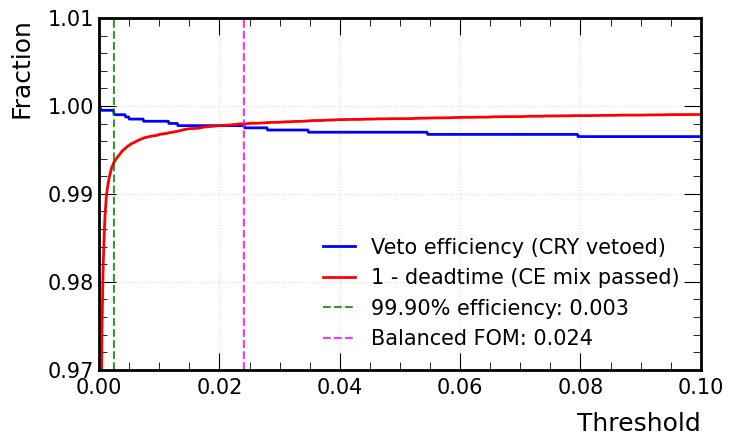

In [28]:
# Create overlay plot
fig, ax = plt.subplots(figsize=(1.2*6.4, 4.8))

ax.plot(thresholds, veto_efficiencies, linewidth=2, color='blue', label='Veto efficiency (CRY vetoed)')
ax.plot(thresholds, 1 - deadtime_losses, linewidth=2, color='red', label='1 - deadtime (CE mix passed)')

# Add vertical lines for your three strategies
ax.axvline(optimal_threshold_eff, color='green', linestyle='--', alpha=0.8, linewidth=1.5,
           label=f'{100*target_efficiency:.2f}% efficiency: {optimal_threshold_eff:.3f}')
ax.axvline(optimal_threshold_fom, color='magenta', linestyle='--', alpha=0.8, linewidth=1.5, label=f'Balanced FOM: {optimal_threshold_fom:.3f}')
# ax.axvline(optimal_threshold_significance, color='orange', linestyle=':', alpha=0.8, 
#            label=f'Signal significance: {optimal_threshold_significance:.3f}')

ax.set_xlabel('Threshold')
ax.set_ylabel('Fraction')
# ax.set_title('Performance vs threshold')
ax.set_ylim([0.97, 1.01])
ax.set_xlim([0, 0.1])
ax.legend(loc='best') # , frameon=True)
ax.grid(alpha=0.4)

plt.tight_layout()

out_name = img_validation_out_path / "threshold_metrics_overlay.png"
plt.savefig(out_name)
print(f"\n✅ Metrics overlay plot saved to {out_name}")

plt.show()

Optimising for efficiency is really the only metric that the CRV group is likely to accept.

In [29]:
optimal_threshold = optimal_threshold_eff 

In [30]:
optimal_threshold

0.0025002500250025004

In [31]:
# import matplotlib.pyplot as plt

# # Separate scores by true label
# signal_scores = test_scores[y_test == 1]  # True signal
# background_scores = test_scores[y_test == 0]  # True background

# plt.figure(figsize=(10, 6))
# plt.hist(background_scores, bins=50, alpha=0.6, label='Cosmics', 
#          density=True, color='orange')
# plt.hist(ce_scores, bins=50, alpha=0.6, label='CEs', 
#          density=True, color='blue')

# plt.axvline(0.5, color='grey', linestyle='--', linewidth=1, 
#             label=f'Threshold = {optimal_threshold}')

# plt.xlabel('Model score')
# plt.ylabel('Density')
# plt.title('Score distribution')
# plt.legend()

# plt.show()

	Wrote ../../../output/images/ml/veto/e/xgboost/validation/h1o_1x2_model_output.png


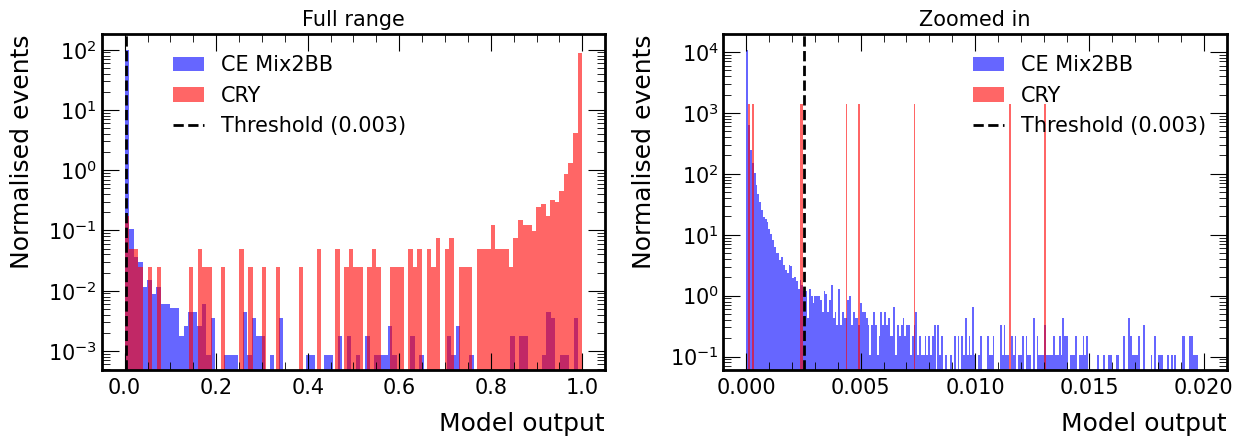

In [32]:
# Get test scores 
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # CRY
background_scores = test_scores[y_test == 0]  # CE + mix2BB

# Define threshold
threshold = optimal_threshold

# Compute FPR and FNR
false_positives = (background_scores > threshold).sum()   # Background misclassified as signal
true_negatives  = (background_scores <= threshold).sum()

false_negatives = (signal_scores <= threshold).sum()  # Signal misclassified as background
true_positives  = (signal_scores > threshold).sum()

fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)

# Plot score distributions
fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 4.8))

nbins = 250
# Left: Full range
ax[0].hist(background_scores, bins=100, alpha=0.6, label='CE Mix2BB',
           density=True, color='blue')
ax[0].hist(signal_scores, bins=100, alpha=0.6, label='CRY',
           density=True, color='red')
ax[0].axvline(optimal_threshold, color='black', linestyle='--', linewidth=2.0, label=f"Threshold ({optimal_threshold:.3f})")
ax[0].set_xlabel('Model output')
ax[0].set_ylabel('Normalised events')
ax[0].legend(loc="upper left", bbox_to_anchor=(0.1, 1))
ax[0].set_yscale('log')
ax[0].set_title('Full range')

# Right: Zoomed in on x-axis around threshold
bins_zoom = np.linspace(0, 0.02, nbins)
ax[1].hist(background_scores, bins=bins_zoom, alpha=0.6, label='CE Mix2BB',
           density=True, color='blue')
ax[1].hist(signal_scores, bins=bins_zoom, alpha=0.6, label='CRY',
           density=True, color='red')
ax[1].axvline(optimal_threshold, color='black', linestyle='--', linewidth=2.0, label=f"Threshold ({optimal_threshold:.3f})")
ax[1].set_xlabel('Model output')
ax[1].set_ylabel('Normalised events')
ax[1].legend(loc="best")
ax[1].set_yscale('log')
# ax[1].set_xlim([0, 0.05])  # Zoomed in range
ax[1].set_title('Zoomed in')

plt.tight_layout()

out_name = img_validation_out_path / "h1o_1x2_model_output.png"
plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()


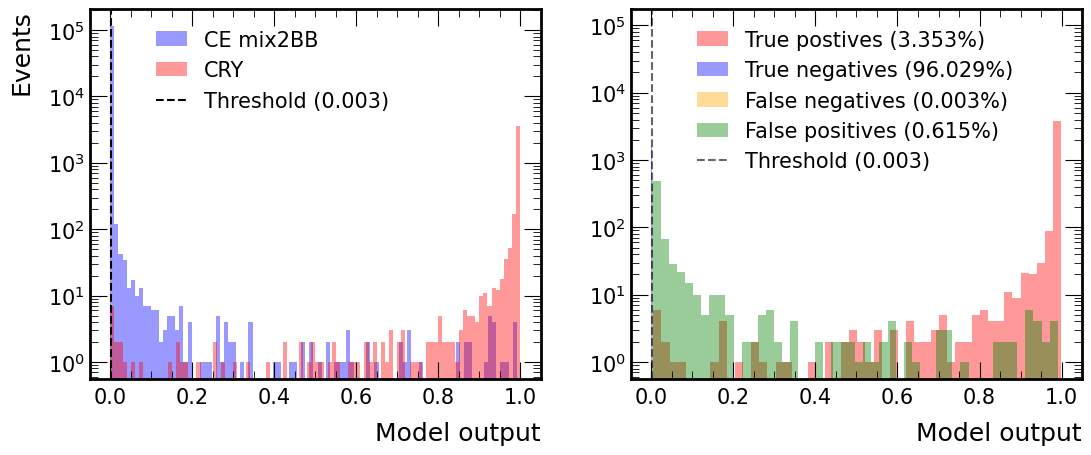

In [33]:
# Get test scores 
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # True signal (CRY)
background_scores = test_scores[y_test == 0]  # True background (CE mix)

# Discrimination threshold
threshold = optimal_threshold

# Get false positives and false negatives
false_positives = background_scores[background_scores > threshold]
false_negatives = signal_scores[signal_scores <= threshold]

# Also get true positives and true negatives for comparison
true_positives = signal_scores[signal_scores > threshold]
true_negatives = background_scores[background_scores <= threshold]

tot = len(test_scores)

# Plot score distributions
fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 4.8))

ax[0].hist(background_scores, bins=100, alpha=0.4, label='CE mix2BB',
         density=False, color='blue')
ax[0].hist(signal_scores, bins=100, alpha=0.4, label='CRY',
         density=False, color='red')
ax[0].axvline(optimal_threshold, color='black', linestyle='--', linewidth=1.5, label=f"Threshold ({optimal_threshold:.3f})")


ax[0].set_xlabel('Model output')
ax[0].set_ylabel('Events')
ax[0].legend(loc="upper left", bbox_to_anchor=(0.1, 1))
ax[0].set_yscale('log')


ax[1].hist(true_positives, bins=50, alpha=0.4, label=f'True postives ({len(true_positives)*100/tot:.3f}%)', color='red')
ax[1].hist(true_negatives, bins=50, alpha=0.4, label=f'True negatives ({len(true_negatives)*100/tot:.3f}%)', color='blue')
ax[1].hist(false_negatives, bins=50, alpha=0.4, label=f'False negatives ({len(false_negatives)*100/tot:.3f}%)', color='orange')
ax[1].hist(false_positives, bins=50, alpha=0.4, label=f'False positives ({len(false_positives)*100/tot:.3f}%)', color='green')
ax[1].axvline(optimal_threshold, color='black', linestyle='--', linewidth=1.5, alpha=0.6, label=f"Threshold ({optimal_threshold:.3f})")


ax[1].set_xlabel('Model output')
ax[1].legend(loc="upper left", bbox_to_anchor=(0.1, 1))
ax[1].set_yscale('log')


out_name = img_validation_out_path / "h1o_1x2_model_output.png"
# plt.savefig(out_name)


plt.show()


In [34]:
# 94.52 + 4.47 + 1.00 + 00.0

	Wrote ../../../output/images/ml/veto/e/xgboost/validation/features_output.png


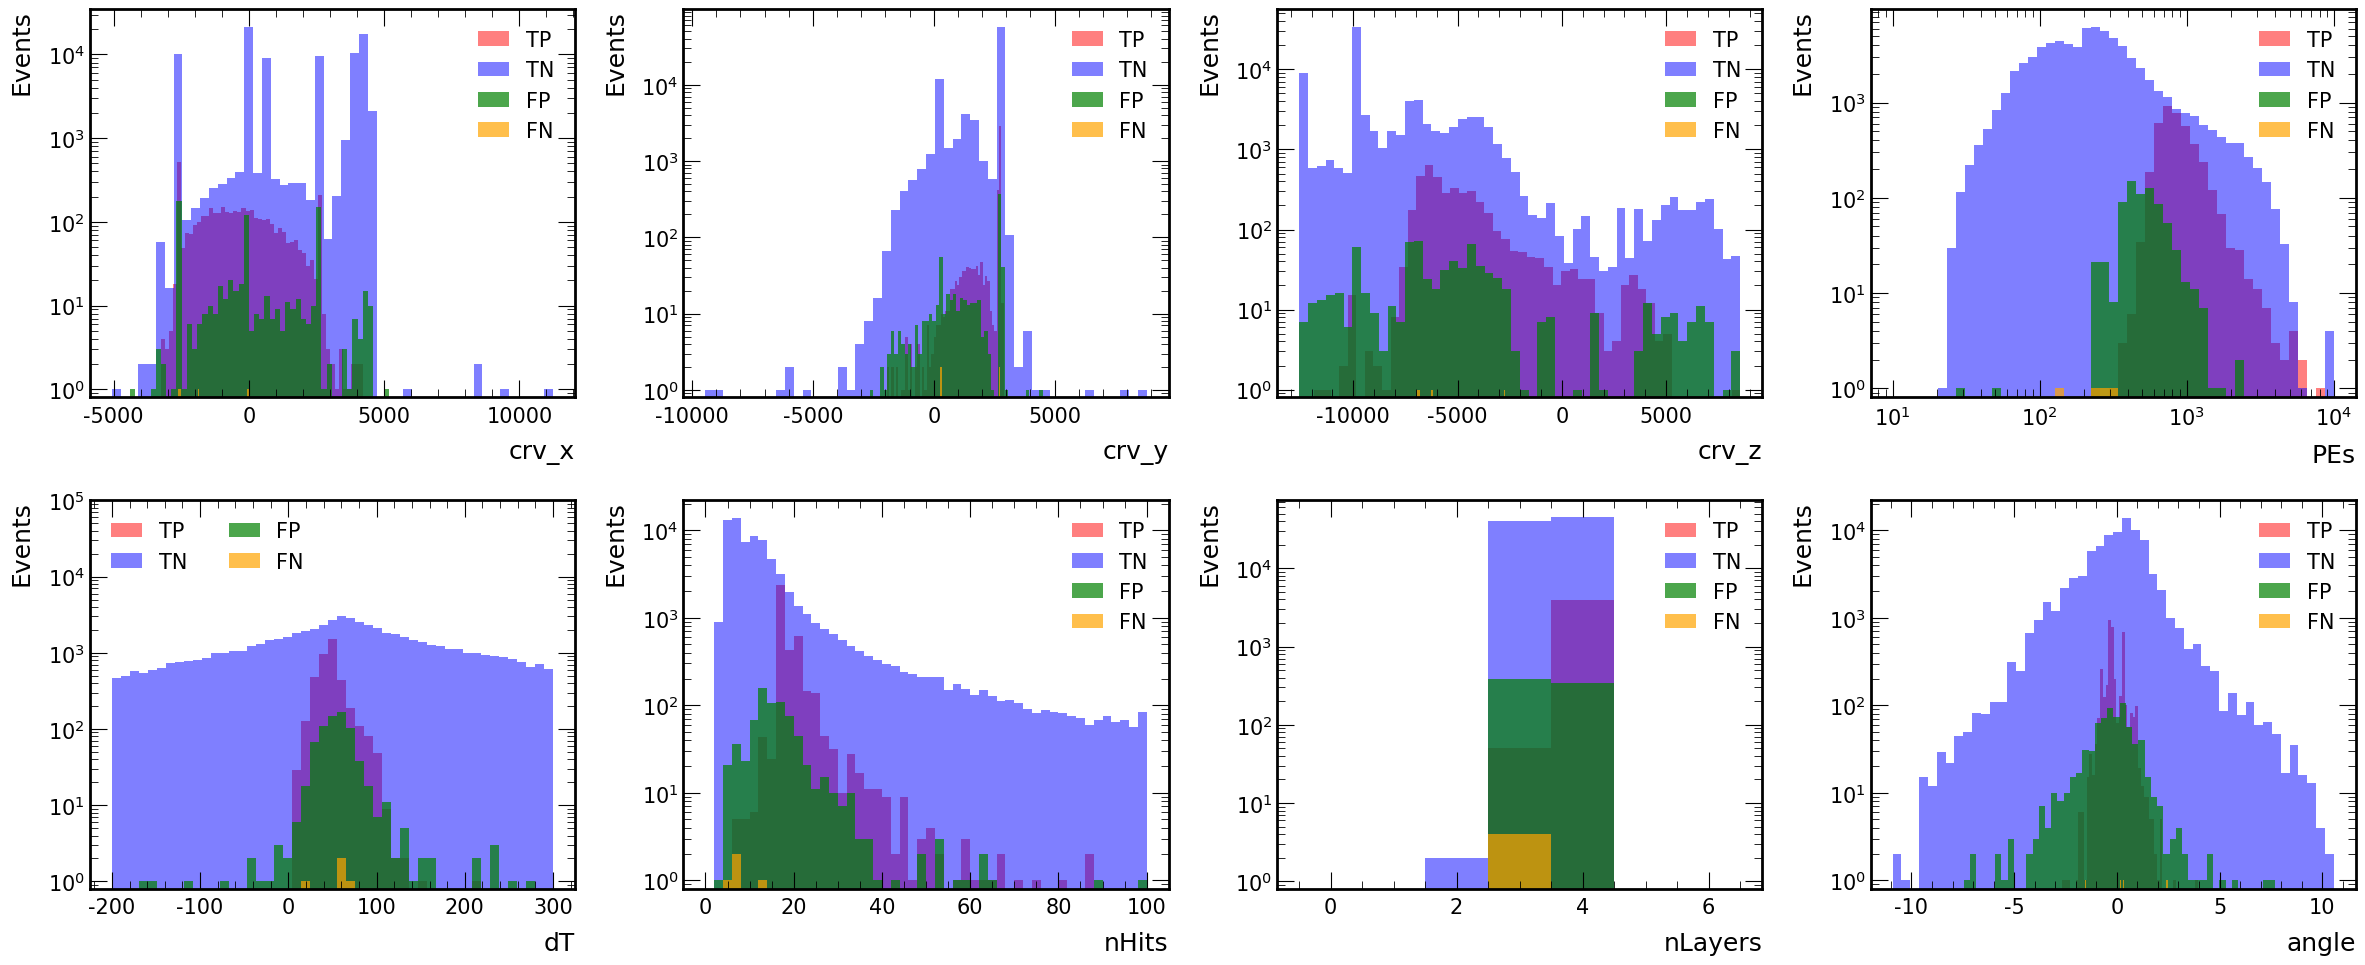

In [35]:
# Create a grid of subplots: 2 rows x 4 columns
n_features = len(feature_names)
n_rows = 2
n_cols = 4

y_pred_label = (test_scores > threshold).astype(int)
# Boolean masks
tp_mask = (y_test == 1) & (y_pred_label == 1)
tn_mask = (y_test == 0) & (y_pred_label == 0)
fp_mask = (y_test == 0) & (y_pred_label == 1)
fn_mask = (y_test == 1) & (y_pred_label == 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*5))
axes = axes.flatten()

for idx, feature in enumerate(feature_names):
    ax = axes[idx]
    
    # Set appropriate binning for each feature
    if feature == 'nLayers':
        # Discrete integer bins for layers (0, 1, 2, 3, 4, 5, 6)
        bins = np.arange(-0.5, 7.5, 1)
    elif feature == 'nHits':
        # Better resolution for hits
        bins = np.linspace(0, 100, 51)
    elif feature == 'PEs':
        # Log-spaced bins for PEs
        bins = np.logspace(np.log10(10), np.log10(10000), 50)
    elif feature in ['crv_x', 'crv_y', 'crv_z']:
        # Position features
        bins = 50
    elif feature == 'angle':
        bins = 50
    elif feature == 'dT':
        bins = np.linspace(-200, 300, 50)
    else:
        bins = 50
    
    ax.hist(X_test[feature][tp_mask], bins=bins, color='red', alpha=0.5, label='TP')
    ax.hist(X_test[feature][tn_mask], bins=bins, color='blue', alpha=0.5, label='TN')
    ax.hist(X_test[feature][fp_mask], bins=bins, color='green', alpha=0.7, label='FP')
    ax.hist(X_test[feature][fn_mask], bins=bins, color='orange', alpha=0.7, label='FN')
    
    xlabel = feature
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Events')
    ax.set_yscale('log')
    
    # Use log x-scale for PEs
    if feature == 'PEs':
        ax.set_xscale('log')
    
    # Set appropriate y-limits to avoid cramped plots
    if feature == 'dT':
        # Higher upper limit for dT to fit legend with 2 columns
        ax.set_ylim(bottom=0.8, top=1e5)
        ax.legend(loc='upper left', framealpha=0.9, ncol=2)
    else:
        ax.set_ylim(bottom=0.8, top=None)
        # Better legend positioning - upper right for most, adjust for specific features
        if feature in ['nLayers', 'crv_x']:
            ax.legend(loc='upper right', framealpha=0.9)
        else:
            ax.legend(loc='upper right', framealpha=0.9)

# Hide unused subplots
for idx in range(len(feature_names), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()

out_name = img_validation_out_path / "features_output.png" 
plt.savefig(out_name)
print(f"\tWrote {out_name}")

plt.show()

## Evaluate on training set 

In [36]:
# Evaluate on training set
y_train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred_proba)

# Evaluate on test set
y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC:  {test_auc:.4f}")
print(f"Difference: {train_auc - test_auc:.4f}")

Train AUC: 0.9999
Test AUC:  0.9999
Difference: -0.0001



✅ Confusion matrix saved to ../../../output/images/ml/veto/e/xgboost/validation/confusion_matrix.png


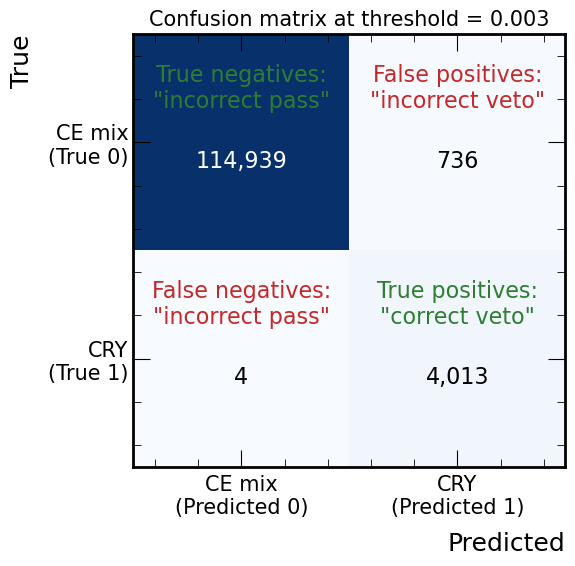

In [37]:
# Visualize confusion matrix with counts and percentages
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Use optimal threshold
y_pred_optimal = (y_test_pred_proba > optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

# Create custom confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))

# Display the confusion matrix as an image
# Try these colormap alternatives:
# 'Blues', 'Greens', 'Purples', 'Oranges', 'Greys'
# 'YlOrRd', 'YlGnBu', 'RdPu', 'BuPu', 'GnBu'
# 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")

# Set ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['CE mix\n(Predicted 0)', 'CRY\n(Predicted 1)'])
ax.set_yticklabels(['CE mix\n(True 0)', 'CRY\n(True 1)'])

ax.set_xlabel('Predicted') # , fontsize=12, fontweight='bold')
ax.set_ylabel('True') # , fontsize=12, fontweight='bold')
ax.set_title(f'Confusion matrix at threshold = {optimal_threshold:.3f}') # , fontsize=13, fontweight='bold')

# Calculate percentages (normalised by row - by true label)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Add text annotations with both counts and percentages
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        count = cm[i, j]
        percentage = cm_norm[i, j] * 100
        
        # Determine if we need white or black text
        text_color = "white" if cm[i, j] > thresh else "black"
        
        # Add interpretation labels at top
        if i == 0 and j == 0:  # TN
            label = 'True negatives:\n"incorrect pass"'
            label_color = '#2E7D32'  # Dark green
        elif i == 0 and j == 1:  # FP
            label = 'False positives:\n"incorrect veto"'
            label_color = '#C62828'  # Dark red
        elif i == 1 and j == 0:  # FN
            label = 'False negatives:\n"incorrect pass"'
            label_color = '#C62828'  # Dark red
        else:  # TP
            label = 'True positives:\n"correct veto"'
            label_color = '#2E7D32'  # Gold/yellow for visibility
        
        ax.text(j, i - 0.25, label,
                ha="center", va="center",
                color=label_color, fontsize=16) # , fontweight='bold')
        
        # Count and percentage below
        ax.text(j, i + 0.15, f'{count:,}\n',
                ha="center", va="center",
                color=text_color, fontsize=16)
                #, fontweight='bold')

plt.tight_layout()

out_name = img_validation_out_path / "confusion_matrix.png"
plt.savefig(out_name) # , dpi=150, bbox_inches='tight')
print(f"\n✅ Confusion matrix saved to {out_name}")

plt.show()

## CRV Veto Performance Metrics

**Physics context**: Veto pure cosmic rays while preserving the CE beam sample.

### Key insight:
The CE mix2BB sample contains:
- True CE signal coincidences 
- Pileup-induced cosmic coincidences

**We want to PASS THROUGH the entire CE mix sample** (both CE signal + pileup cosmics) because:
- Vetoing pileup cosmics = unnecessary deadtime inflation
- Pileup cosmics in CE mix don't contaminate the physics signal the same way pure cosmics do

### Training strategy:
- **Label 1 (CRY)**: Pure cosmic sample → VETO these
- **Label 0 (CE mix)**: Mixed CE sample → PASS these (accept both CE + pileup)

### Model performance metrics:
- **Veto Efficiency (ε_veto)**: Fraction of pure cosmic rays correctly vetoed
- **Veto Inefficiency (1 - ε_veto)**: Fraction of pure cosmic rays that slip through (contamination)
- **Deadtime**: Fraction of CE mix events incorrectly vetoed (pure loss)
- **Veto Purity**: Of vetoed events, what fraction are truly from pure cosmic sample

In [38]:
# ==========================================
# CRV VETO PERFORMANCE METRICS
# ==========================================

# LABELS:
#   Label 1 (CRY): Pure cosmic sample - want to VETO
#   Label 0 (CE mix): Mixed CE sample (true CE + pileup cosmics) - want to PASS
#
# PHYSICS GOAL:
#   VETO: Pure cosmic rays (out-of-time backgrounds)
#   PASS: Entire CE mix sample (CE signal + pileup cosmics)
#   
#   Why pass pileup cosmics? Vetoing them inflates deadtime without benefit!

# Get predictions at optimal threshold
y_pred_veto = (y_test_pred_proba > optimal_threshold).astype(int)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_veto)
tn, fp, fn, tp = cm.ravel()

# Core veto metrics
veto_efficiency = tp / (tp + fn)  # Fraction of pure cosmics caught
veto_inefficiency = fn / (tp + fn)  # Fraction of pure cosmics that leak through
deadtime_loss = fp / (tn + fp)  # Fraction of CE mix incorrectly vetoed
veto_purity = tp / (tp + fp) if (tp + fp) > 0 else 0  # Of vetoed events, fraction that are pure cosmics

In [39]:
# ==========================================
# SAVE CRV VETO METRICS TO CSV
# ==========================================

# Create results directory
results_out_path = Path(f"../../../output/ml/veto/xgboost/{run}/results")
results_out_path.mkdir(parents=True, exist_ok=True)

# Calculate all metrics
metrics_data = {
    'Metric': [
        'Veto efficiency (Pure CRY)',
        'Veto inefficiency (Pure CRY)', 
        'CE mix veto rate (Additional deadtime)',
        'CE mix pass rate',
        'Veto purity',
        'Overall accuracy'
    ],
    'Formula': [
        'TP / (TP + FN)',
        'FN / (TP + FN)',
        'FP / (TN + FP)',
        'TN / (TN + FP)',
        'TP / (TP + FP)',
        '(TP + TN) / (TP + TN + FP + FN)'
    ],
    'Value': [
        veto_efficiency,
        veto_inefficiency,
        deadtime_loss,
        1 - deadtime_loss,  # CE Mix Pass Rate = 1 - deadtime
        veto_purity,
        (tp + tn) / (tp + tn + fp + fn)
    ],
    'Description': [
        'Fraction of pure cosmic rays vetoed',
        'Fraction of pure cosmic rays passed',
        'Fraction of CE mix events vetoed (deadtime)',
        'Fraction of CE mix events passed',
        'Of all vetoed events, fraction that are pure cosmics',
        'Overall correct classification rate'
    ]
}

# Add confusion matrix counts
confusion_data = {
    'Metric': ['True Positives (TP)', 'True Negatives (TN)', 'False Positives (FP)', 'False Negatives (FN)'],
    'Count': [int(tp), int(tn), int(fp), int(fn)],
    'Description': [
        'Pure CRY correctly vetoed',
        'CE mix correctly passed',
        'CE mix incorrectly vetoed',
        'Pure CRY incorrectly passed'
    ]
}

# Create DataFrames
metrics_df = pd.DataFrame(metrics_data)
confusion_df = pd.DataFrame(confusion_data)

# Save to CSV files
metrics_file_path = results_out_path / "crv_metrics_results.csv"
confusion_file_path = results_out_path / "confusion_matrix_counts.csv"

metrics_df.to_csv(metrics_file_path, index=False, float_format='%.6f')
confusion_df.to_csv(confusion_file_path, index=False)

print(f"\n✅ CRV metrics saved to:")
print(f"   {metrics_file_path}")
print(f"   {confusion_file_path}")

# Display the results
print("\n" + "="*80)
print("CRV VETO METRICS SUMMARY")
print("="*80)
display(metrics_df)

print("\n" + "="*80)
print("CONFUSION MATRIX COUNTS")
print("="*80)
display(confusion_df)



✅ CRV metrics saved to:
   ../../../output/ml/veto/xgboost/e/results/crv_metrics_results.csv
   ../../../output/ml/veto/xgboost/e/results/confusion_matrix_counts.csv

CRV VETO METRICS SUMMARY


,Metric,Formula,Value,Description
0,Veto efficiency (Pure CRY),TP / (TP + FN),0.999004,Fraction of pure cosmic rays vetoed
1,Veto inefficiency (Pure CRY),FN / (TP + FN),0.000996,Fraction of pure cosmic rays passed
2,CE mix veto rate (Additional deadtime),FP / (TN + FP),0.006363,Fraction of CE mix events vetoed (deadtime)
3,CE mix pass rate,TN / (TN + FP),0.993637,Fraction of CE mix events passed
4,Veto purity,TP / (TP + FP),0.845020,"Of all vetoed events, fraction that are pure c..."
5,Overall accuracy,(TP + TN) / (TP + TN + FP + FN),0.993817,Overall correct classification rate



CONFUSION MATRIX COUNTS


,Metric,Count,Description
0,True Positives (TP),4013,Pure CRY correctly vetoed
1,True Negatives (TN),114939,CE mix correctly passed
2,False Positives (FP),736,CE mix incorrectly vetoed
3,False Negatives (FN),4,Pure CRY incorrectly passed


## Comparison with simple dT cut

Compare ML performance with traditional veto window: -25 < dT < 150 ns

In [40]:
# ==========================================
# SIMPLE dT CUT COMPARISON
# ==========================================
# Apply traditional veto window: -25 < dT < 150 ns
# If dT is in this window, predict it's a cosmic (label 1)

# Get dT values from test set! This is 20%, so expect 20% unvetoed events compared to conventional analysis
dT_test = X_test['dT'].values

# Apply simple cut: veto if dT in [-25, 150]
y_pred_dt_cut = ((dT_test >= -25) & (dT_test <= 150)).astype(int)

# # Get dT values from test set
# dT = X['dT'].values

# # Apply simple cut: veto if dT in [-25, 150]
# y_pred_dt_cut = ((dT >= -25) & (dT <= 150)).astype(int)




# Calculate confusion matrix for dT cut
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(y_test, y_pred_dt_cut)
tn_dt, fp_dt, fn_dt, tp_dt = cm_dt.ravel()

# Calculate metrics for dT cut
veto_efficiency_dt = tp_dt / (tp_dt + fn_dt)
veto_inefficiency_dt = fn_dt / (tp_dt + fn_dt)
deadtime_loss_dt = fp_dt / (tn_dt + fp_dt)
veto_purity_dt = tp_dt / (tp_dt + fp_dt) if (tp_dt + fp_dt) > 0 else 0

# Create comprehensive "money table" with ALL metrics
print("\n" + "="*80)
print("PERFORMANCE COMPARISON: ML MODEL vs SIMPLE dT CUT")
print("="*80)

# Calculate all metrics for both approaches
ml_pass_rate = 1 - deadtime_loss
dt_pass_rate = 1 - deadtime_loss_dt
ml_accuracy = (tp + tn) / (tp + tn + fp + fn)
dt_accuracy = (tp_dt + tn_dt) / (tp_dt + tn_dt + fp_dt + fn_dt)
ml_fom = veto_efficiency * (1 - deadtime_loss)
dt_fom = veto_efficiency_dt * (1 - deadtime_loss_dt)

# Complete metrics comparison table
metrics_comparison_df = pd.DataFrame({
    'Metric': [
        'Veto efficiency',
        # 'Veto inefficiency (Pure CRY)',
        'Deadtime',
        # 'CE mix pass rate',
        'Veto purity',
        'Overall accuracy',
        'Figure of merit'
    ],
    'ML model': [
        f"{veto_efficiency*100:.3f}%",
        # f"{veto_inefficiency*100:.2f}%",
        f"{deadtime_loss*100:.3f}%",
        # f"{ml_pass_rate*100:.2f}%",
        f"{veto_purity*100:.3f}%",
        f"{ml_accuracy*100:.3f}%",
        f"{ml_fom*100:.3f}%"
    ],
    'dT cut [-25, 150] ns': [
        f"{veto_efficiency_dt*100:.3f}%",
        # f"{veto_inefficiency_dt*100:.2f}%",
        f"{deadtime_loss_dt*100:.3f}%",
        # f"{dt_pass_rate*100:.2f}%",
        f"{veto_purity_dt*100:.3f}%",
        f"{dt_accuracy*100:.3f}%",
        f"{dt_fom*100:.3f}%"
    ],
    'Difference': [
        f"{(veto_efficiency - veto_efficiency_dt)*100:+.3f}%",
        # f"{(veto_inefficiency - veto_inefficiency_dt)*100:+.2f}%",
        f"{(deadtime_loss - deadtime_loss_dt)*100:+.3f}%",
        # f"{(ml_pass_rate - dt_pass_rate)*100:+.2f}%",
        f"{(veto_purity - veto_purity_dt)*100:+.3f}%",
        f"{(ml_accuracy - dt_accuracy)*100:+.3f}%",
        f"{(ml_fom - dt_fom)*100:+.3f}%"
    ],
    'Description': [
        'Fraction of cosmics vetoed',
        # 'Fraction of pure cosmic rays passed (contamination)',
        'Fraction of pileup vetoed',
        # 'Fraction of CE mix events passed',
        'Of all vetoed events, fraction that are cosmics',
        'Overall correct classification rate',
        'eff_veto * (1 - deadtime)'
    ]
})

# Confusion matrix comparison
confusion_comparison_df = pd.DataFrame({
    'Category': [
        'True Positives (CRY vetoed)',
        'True Negatives (CE mix passed)',
        'False Positives (CE mix vetoed)',
        'False Negatives (CRY passed)'
    ],
    'ML model': [tp, tn, fp, fn],
    'dT cut': [tp_dt, tn_dt, fp_dt, fn_dt],
    'Difference': [tp - tp_dt, tn - tn_dt, fp - fp_dt, fn - fn_dt]
})

print("\n📊 COMPLETE PERFORMANCE METRICS COMPARISON:")
display(metrics_comparison_df)

print("\n📈 Confusion Matrix Counts:")
display(confusion_comparison_df)

# Save to CSV files
metrics_file_path = results_out_path / "crv_metrics_comparison_money_table.csv"
confusion_file_path = results_out_path / "confusion_matrix_comparison_counts.csv"

metrics_comparison_df.to_csv(metrics_file_path, index=False)
confusion_comparison_df.to_csv(confusion_file_path, index=False)

print(f"\n✅ CRV metrics saved to:")
print(f"   {metrics_file_path}")
print(f"   {confusion_file_path}")

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

# Veto efficiency comparison
print(f"\nVeto efficiency (catching pure CRY):")
print(f"   ML: {tp:,}/{tp+fn:,} CRY vetoed ({veto_efficiency*100:.2f}%)")
print(f"   dT: {tp_dt:,}/{tp_dt+fn_dt:,} CRY vetoed ({veto_efficiency_dt*100:.2f}%)")
print(f"   → ML catches {tp - tp_dt:,} {'fewer' if tp < tp_dt else 'more'} CRY events ({(veto_efficiency - veto_efficiency_dt)*100:+.2f}%)")

# CRY leakage comparison
print(f"\nCRY leakage (contamination):")
print(f"   ML: {fn:,} CRY leaked ({veto_inefficiency*100:.4f}%)")
print(f"   dT: {fn_dt:,} CRY leaked ({veto_inefficiency_dt*100:.4f}%)")
print(f"   → ML leaks {abs(fn - fn_dt):,} {'fewer' if fn < fn_dt else 'more'} CRY events ({(veto_inefficiency - veto_inefficiency_dt)*100:+.4f}%)")

# Deadtime comparison
print(f"\nAdditional deadtime (CE mix incorrectly vetoed):")
print(f"   ML: {fp:,}/{fp+tn:,} CE mix vetoed ({deadtime_loss*100:.2f}%)")
print(f"   dT: {fp_dt:,}/{fp_dt+tn_dt:,} CE mix vetoed ({deadtime_loss_dt*100:.2f}%)")
print(f"   → ML vetoes {abs(fp - fp_dt):,} {'fewer' if fp < fp_dt else 'more'} CE mix events ({(deadtime_loss - deadtime_loss_dt)*100:+.2f}%)")

# Overall trade-off
print(f"\nTrade-off summary:")
print(f"   ML sacrifices {abs(tp - tp_dt):,} CRY vetoes")
print(f"   To gain {abs(tn - tn_dt):,} CE mix passes")
print(f"   Net benefit: {abs(deadtime_loss - deadtime_loss_dt)*100:.1f}% deadtime reduction vs {abs(veto_efficiency - veto_efficiency_dt)*100:.3f}% efficiency loss")

print("="*80)


PERFORMANCE COMPARISON: ML MODEL vs SIMPLE dT CUT

📊 COMPLETE PERFORMANCE METRICS COMPARISON:


,Metric,ML model,"dT cut [-25, 150] ns",Difference,Description
0,Veto efficiency,99.900%,99.950%,-0.050%,Fraction of cosmics vetoed
1,Deadtime,0.636%,31.110%,-30.474%,Fraction of pileup vetoed
2,Veto purity,84.502%,10.037%,+74.465%,"Of all vetoed events, fraction that are cosmics"
3,Overall accuracy,99.382%,69.932%,+29.450%,Overall correct classification rate
4,Figure of merit,99.265%,68.855%,+30.410%,eff_veto * (1 - deadtime)



📈 Confusion Matrix Counts:


,Category,ML model,dT cut,Difference
0,True Positives (CRY vetoed),4013,4015,-2
1,True Negatives (CE mix passed),114939,79688,35251
2,False Positives (CE mix vetoed),736,35987,-35251
3,False Negatives (CRY passed),4,2,2



✅ CRV metrics saved to:
   ../../../output/ml/veto/xgboost/e/results/crv_metrics_comparison_money_table.csv
   ../../../output/ml/veto/xgboost/e/results/confusion_matrix_comparison_counts.csv

KEY FINDINGS

Veto efficiency (catching pure CRY):
   ML: 4,013/4,017 CRY vetoed (99.90%)
   dT: 4,015/4,017 CRY vetoed (99.95%)
   → ML catches -2 fewer CRY events (-0.05%)

CRY leakage (contamination):
   ML: 4 CRY leaked (0.0996%)
   dT: 2 CRY leaked (0.0498%)
   → ML leaks 2 more CRY events (+0.0498%)

Additional deadtime (CE mix incorrectly vetoed):
   ML: 736/115,675 CE mix vetoed (0.64%)
   dT: 35,987/115,675 CE mix vetoed (31.11%)
   → ML vetoes 35,251 fewer CE mix events (-30.47%)

Trade-off summary:
   ML sacrifices 2 CRY vetoes
   To gain 35,251 CE mix passes
   Net benefit: 30.5% deadtime reduction vs 0.050% efficiency loss
